---

### **Step 0 - Importing Libraries**

---

In [1]:
# Manipulation data
import numpy as np
import pandas as pd
import csv
import glob
import datetime

# Grapichs
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Machine Learning
import sklearn

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.inspection import permutation_importance

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV

import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.cluster import KMeans

# statistical analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# For warnings
pd.options.mode.chained_assignment = None  
import warnings
warnings.filterwarnings("ignore")

---

### **Step 1 - Load Data to Model**

---

In [2]:
# Read the .csv files
data_base = pd.read_csv(r'E:\Projetos\TCC\data_TCC_selected_stations.csv', delimiter=",")

# Drop the index column
data_base.drop(data_base.columns[0], axis=1, inplace=True)

# Rename the columns
rename_dict = {
    'Data Medicao': 'data',
    'Hora Medicao': 'hora',
    'PRECIPITACAO TOTAL, HORARIO(mm)': 'precipitacao',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)': 'pressao_atm',
    'RADIACAO GLOBAL(Kj/m²)': 'radiacao',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)': 'temperatura',
    'TEMPERATURA DO PONTO DE ORVALHO(°C)': 'temp_orvalho',
    'UMIDADE RELATIVA DO AR, HORARIA(%)': 'umidade',
    'VENTO, DIRECAO HORARIA (gr)(° (gr))': 'direcao_vento',
    'VENTO, RAJADA MAXIMA(m/s)': 'vento_maximo',
    'VENTO, VELOCIDADE HORARIA(m/s)': 'velocidade'
}

data_base.rename(columns=rename_dict, inplace=True)

# Reorder the columns
new_order = ['estacao', 
            'latitude', 
            'longitude', 
            'data', 
            'hora', 
            'radiacao', 
            'temperatura', 
            'umidade', 
            'precipitacao', 
            'pressao_atm', 
            'temp_orvalho', 
            'direcao_vento', 
            'vento_maximo', 
            'velocidade']

if all(col in data_base.columns for col in new_order):
    data_base = data_base[new_order]
else:
    missing_cols = [col for col in new_order if col not in data_base.columns]
    error_message = "Missing columns in data: " + ", ".join(missing_cols)

# Adjust the hour to standart
data_adjusted = data_base.copy()

hora_mapping = {
    0: 21, 100: 22, 200: 23, 300: 0, 400: 1, 500: 2,
    600: 3, 700: 4, 800: 5, 900: 6, 1000: 7, 1100: 8,
    1200: 9, 1300: 10, 1400: 11, 1500: 12, 1600: 13,
    1700: 14, 1800: 15, 1900: 16, 2000: 17, 2100: 18,
    2200: 19, 2300: 20
}

data_adjusted['hora'] = data_base['hora'].replace(hora_mapping)

# Removing outliers
# +- 3,5 std dev on mean for each hour 
data_adjusted_no_outliers = data_adjusted.copy()
data = pd.DataFrame()

for hour in range(24):
    dados_hour = data_adjusted_no_outliers[data_adjusted_no_outliers['hora'] == hour]
    
    mean_radiacao = np.mean(dados_hour['radiacao'])
    std_radiacao = np.std(dados_hour['radiacao'])

    lower = mean_radiacao - 3.5 * std_radiacao
    upper = mean_radiacao + 3.5 * std_radiacao

    y = dados_hour.query('radiacao >= @lower and radiacao <= @upper')

    data = pd.concat([data, y], ignore_index=True)

# Display the data
display(data)

estacao   latitude  longitude        data  hora  radiacao  \
0           ARAXA -19.605696 -46.949617  2010-01-01     0    -0.068   
1           ARAXA -19.605696 -46.949617  2010-01-02     0    -1.276   
2           ARAXA -19.605696 -46.949617  2010-01-03     0    -3.540   
3           ARAXA -19.605696 -46.949617  2010-01-04     0    -3.540   
4           ARAXA -19.605696 -46.949617  2010-01-05     0    -3.540   
...           ...        ...        ...         ...   ...       ...   
6456106  SELVIRIA -20.351444 -51.430222  2019-09-16    23    -3.600   
6456107  SELVIRIA -20.351444 -51.430222  2019-09-17    23    -3.600   
6456108  SELVIRIA -20.351444 -51.430222  2019-09-18    23    -3.600   
6456109  SELVIRIA -20.351444 -51.430222  2019-09-19    23    -3.598   
6456110  SELVIRIA -20.351444 -51.430222  2019-09-20    23    -3.600   

         temperatura  umidade  precipitacao  pressao_atm  temp_orvalho  \
0               20.1     94.0           0.6        899.0          19.1   
1               20.8     88.0           0.0        900.7          18.7   
2               22.1     72.0           0.0        902.0          16.8   
3               21.9     65.0           0.0        902.2          15.0   
4               23.4     66.0           0.0        902.0          16.6   
...              ...      ...           ...          ...           ...   
6456106         25.9     42.0           0.0        969.9          11.9   
6456107         25.8     41.0           0.0        970.0          11.7   
6456108         27.7     32.0           0.0        965.1           9.7   
6456109         27.8     57.0           0.0        965.2          18.5   
6456110         32.0     34.0           0.0        965.5          14.0   

         direcao_vento  vento_maximo  velocidade  
0                358.0           4.8         1.1  
1                 70.0           4.0         1.1  
2                 76.0           5.7         3.6  
3                104.0           4.6         2.9  
4                 70.0           3.2         1.6  
...                ...           ...         ...  
6456106           42.0           6.3         1.6  
6456107          347.0           2.6         1.1  
6456108           74.0           3.1         1.6  
6456109          191.0           5.8         2.7  
6456110          291.0           7.2         4.9  

[6456111 rows x 14 columns]

#### Step 1.1 - Special treatment in repeated data - INCLUDE in TCC

Alta concentracao de dados semelhantes em uma mesma estacao

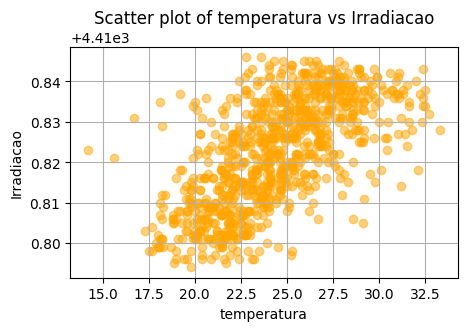

estacoes: ['RIO DO CAMPO']
data min: 2011-11-23
data max: 2012-04-18
rows: 886
Original number of rows: 6456111
Number of rows after filtering: 6455225


In [3]:
# Plot the gap
filtered_data = data[(data['radiacao'] >= 4410.75) & (data['radiacao'] <= 4410.85)]

plt.figure(figsize=(5, 3))
plt.scatter(filtered_data['temperatura'], filtered_data['radiacao'], alpha=0.5, color='orange')
plt.xlabel('temperatura')
plt.ylabel('Irradiacao')
plt.title('Scatter plot of temperatura vs Irradiacao')
plt.grid(True)
plt.show()

# Check the data
estacoes = (filtered_data['estacao'].unique())

min_datetime = filtered_data['data'].min()
max_datetime = filtered_data['data'].max()

print(f'estacoes: {estacoes}')
print(f'data min: {min_datetime}')
print(f'data max: {max_datetime}')
print(f'rows: {len(filtered_data)}')

# Remove these rows
df = data.copy()

filter_condition = (df['radiacao'] >= 4410.75) & (df['radiacao'] <= 4410.85) & (df['estacao'] == 'RIO DO CAMPO')

df_filtered = df[~filter_condition]

print(f"Original number of rows: {len(data)}")
print(f"Number of rows after filtering: {len(df_filtered)}")

#### Step 1.2 - Select variables

Based on primary researchs, we'll just work with 'hora', 'temperatura', 'umidade' and 'precipitacao'

In [4]:
data_model = pd.DataFrame({'estacao': df_filtered['estacao'],
                           'data': df_filtered['data'],
                           'hora': df_filtered['hora'],
                           'radiacao': df_filtered['radiacao'],
                           'temperatura': df_filtered['temperatura'],
                           'umidade': df_filtered['umidade'],
                           'precipitacao': df_filtered['precipitacao']})

(data_model['radiacao'] < 0).sum()

data_model_zero = data_model.copy()

data_model_zero.loc[data_model['radiacao'] < 0, 'radiacao'] = 0

#### Step 1.3 - Reduction treatment in data

In [5]:
data_no_red = pd.DataFrame({'estacao': data_model_zero['estacao'],
                            'data': data_model_zero['data']})

data_model_red = pd.DataFrame({'hora': data_model_zero['hora'],
                         'radiacao': data_model_zero['radiacao'],
                         'temperatura': data_model_zero['temperatura'],
                         'umidade': data_model_zero['umidade'],
                         'precipitacao': data_model_zero['precipitacao']})

data_model_red['sum'] = data_model_red.apply(lambda row: round(sum(row), 4), axis=1)

data_model_red = data_model_red.drop_duplicates(subset='sum')

data_model_red = data_model_red.drop('sum', axis=1)

data_model_red = data_model_red.join(data_no_red, how='left')

data_model_red = data_model_red.reindex(columns=['estacao', 'data', 'hora', 'radiacao', 'temperatura', 'umidade', 'precipitacao'])

display(data_model_red)

estacao        data  hora  radiacao  temperatura  umidade  \
0                   ARAXA  2010-01-01     0     0.000         20.1     94.0   
1                   ARAXA  2010-01-02     0     0.000         20.8     88.0   
2                   ARAXA  2010-01-03     0     0.000         22.1     72.0   
3                   ARAXA  2010-01-04     0     0.000         21.9     65.0   
4                   ARAXA  2010-01-05     0     0.000         23.4     66.0   
...                   ...         ...   ...       ...          ...      ...   
6436441          MORRETES  2017-08-21    23   305.917         13.6     98.0   
6436442          MORRETES  2017-09-30    23   388.283         18.2     99.0   
6436455          MORRETES  2018-08-19    23   235.420         17.3     99.0   
6447774  CAMPINA DA LAGOA  2020-04-06    23   468.769         21.5     99.0   
6452916          IGUATEMI  2021-01-25    23     0.880         21.2     95.0   

         precipitacao  
0                 0.6  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  
...               ...  
6436441           0.0  
6436442           9.2  
6436455           0.0  
6447774           3.0  
6452916           0.0  

[2098306 rows x 7 columns]

#### Step 1.4 - Data histogram

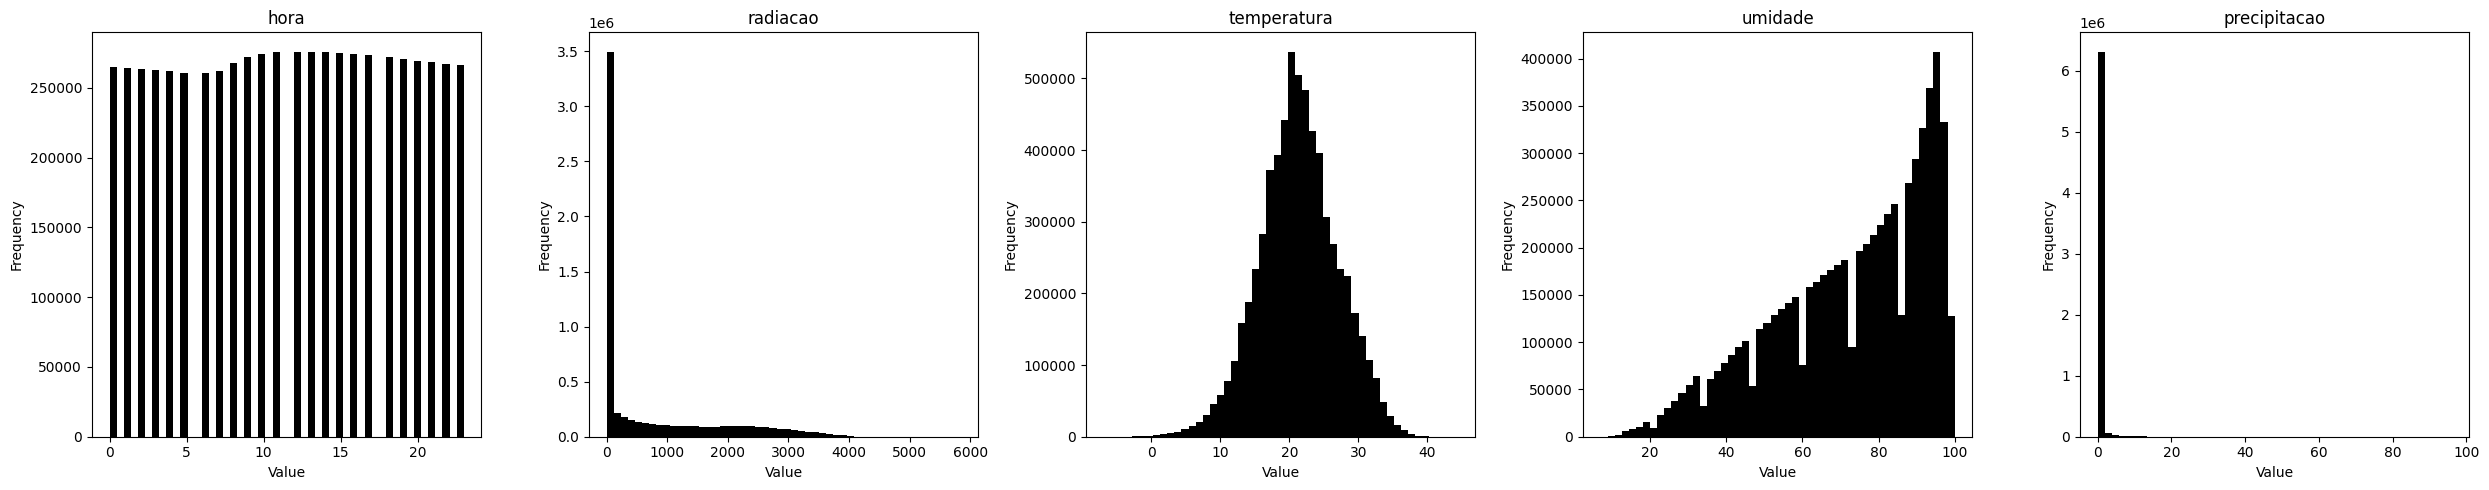

In [6]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, variable in enumerate(['hora', 'radiacao', 'temperatura', 'umidade', 'precipitacao']):
    axs[i].hist(data_model_zero[variable], bins=50, alpha=1, color='black')
    axs[i].set_title(variable)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

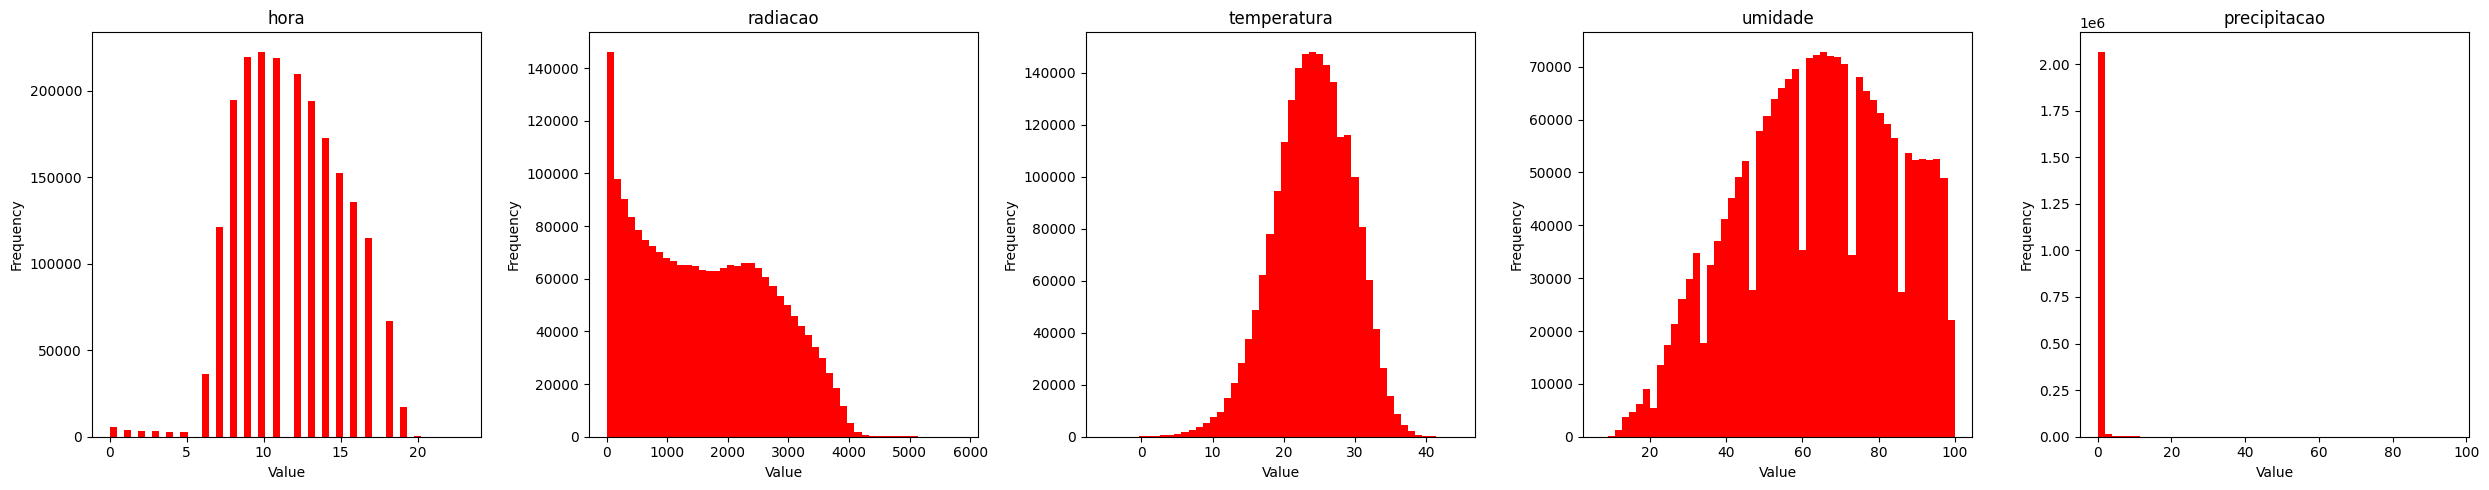

In [7]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, variable in enumerate(['hora', 'radiacao', 'temperatura', 'umidade', 'precipitacao']):
    axs[i].hist(data_model_red[variable], bins=50, alpha=1, color='red')
    axs[i].set_title(variable)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

---

### **Step 2 - Clustering Process**

---

#### Step 2.1 - Kmeans

In [9]:
def clustering_Kmeans(df, variables):

    # Extract the relevant variables for clustering
    data_for_clustering = df[variables]

    # Fit the K-Means model
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(data_for_clustering)

    # Add the cluster labels to the original dataframe
    df['Cluster'] = kmeans.labels_

    cluster_0 = df[df['Cluster'] == 0]
    cluster_1 = df[df['Cluster'] == 1]

    ##################################################################

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Cluster 0
    axs[0].scatter(cluster_0['hora'], cluster_0['radiacao'], alpha=0.1, color='green')
    axs[0].set_xlabel("hora")
    axs[0].set_ylabel("irradiação (Kj/m2)")
    axs[0].tick_params(axis='both', which='both', labelsize=14)
    axs[0].set_xlim([-1, 24]) 
    axs[0].set_ylim([-200, 6000]) 
    axs[0].set_title(f'Cluster 0 ({len(cluster_0)})')

    # Cluster 1
    axs[1].scatter(cluster_1['hora'], cluster_1['radiacao'], alpha=0.1, color='blue')
    axs[1].set_xlabel("hora")
    axs[1].set_ylabel("irradiação (Kj/m2)")
    axs[1].tick_params(axis='both', which='both', labelsize=14)
    axs[1].set_xlim([-1, 24]) 
    axs[1].set_ylim([-200, 6000]) 
    axs[1].set_title(f'Cluster 1 ({len(cluster_1)})')

    plt.suptitle('Clusters - hora vs radiacao')
    plt.tight_layout()
    plt.show()

    ##################################################################

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Cluster 0
    axs[0].scatter(df[df['Cluster'] == 0]['temperatura'], df[df['Cluster'] == 0]['umidade'], label='Cluster 0', c='green', marker='o', alpha=0.1)
    axs[0].set_xlabel('Temperatura')
    axs[0].set_ylabel('Umidade')
    axs[0].set_xlim([-10, 50])  
    axs[0].set_ylim([-10, 110])  
    axs[0].set_title(f'Cluster 0 ({len(cluster_0)})')
    axs[0].legend()

    # Cluster 1
    axs[1].scatter(df[df['Cluster'] == 1]['temperatura'], df[df['Cluster'] == 1]['umidade'], label='Cluster 1', c='blue', marker='o', alpha=0.1)
    axs[1].set_xlabel('Temperatura')
    axs[1].set_ylabel('Umidade')
    axs[1].set_xlim([-10, 50])  
    axs[1].set_ylim([-10, 110])  
    axs[1].set_title(f'Cluster 1 ({len(cluster_1)})')
    axs[1].legend()

    plt.suptitle('Clusters - Temperatura vs Umidade')
    plt.show()

    ##################################################################

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Cluster 0
    axs[0].scatter(df[df['Cluster'] == 0]['radiacao'], df[df['Cluster'] == 0]['precipitacao'], label='Cluster 0', c='green', marker='o', alpha=0.1)
    axs[0].set_xlabel('radiacao')
    axs[0].set_ylabel('precipitacao')
    axs[0].set_xlim([-200, 6000])  
    axs[0].set_ylim([-10, 110])  
    axs[0].set_title(f'Cluster 0 ({len(cluster_0)})')
    axs[0].legend()

    # Cluster 1
    axs[1].scatter(df[df['Cluster'] == 1]['radiacao'], df[df['Cluster'] == 1]['precipitacao'], label='Cluster 1', c='blue', marker='o', alpha=0.1)
    axs[1].set_xlabel('radiacao')
    axs[1].set_ylabel('precipitacao')
    axs[1].set_xlim([-200, 6000])
    axs[1].set_ylim([-10, 110])  
    axs[1].set_title(f'Cluster 1 ({len(cluster_1)})')
    axs[1].legend()

    plt.suptitle('Clusters - radiacao vs precipitacao')
    plt.show()

    ##################################################################

    return cluster_0, cluster_1

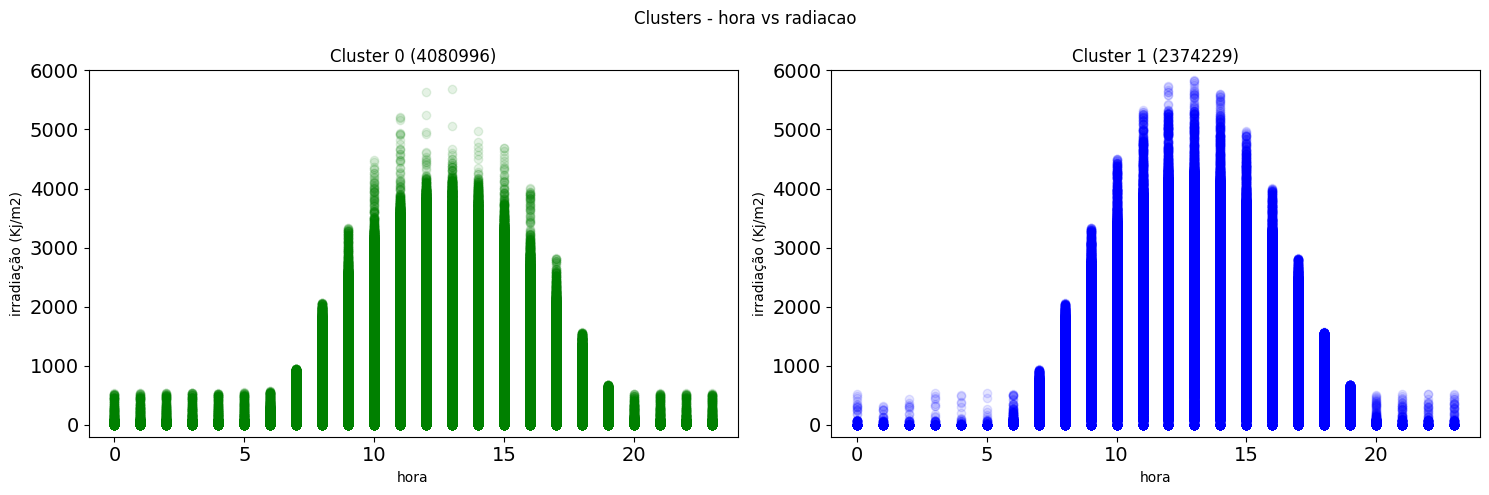

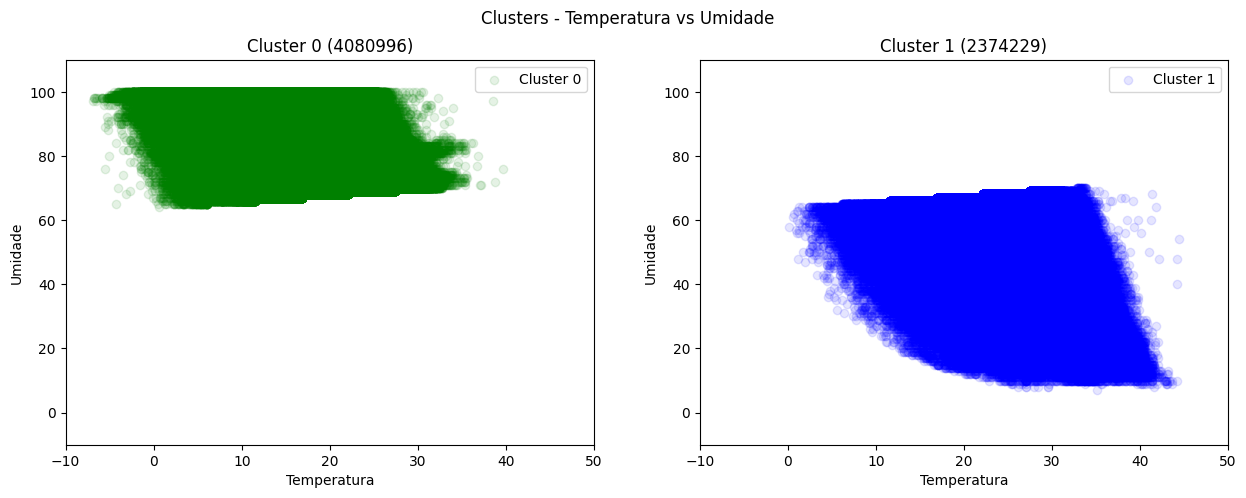

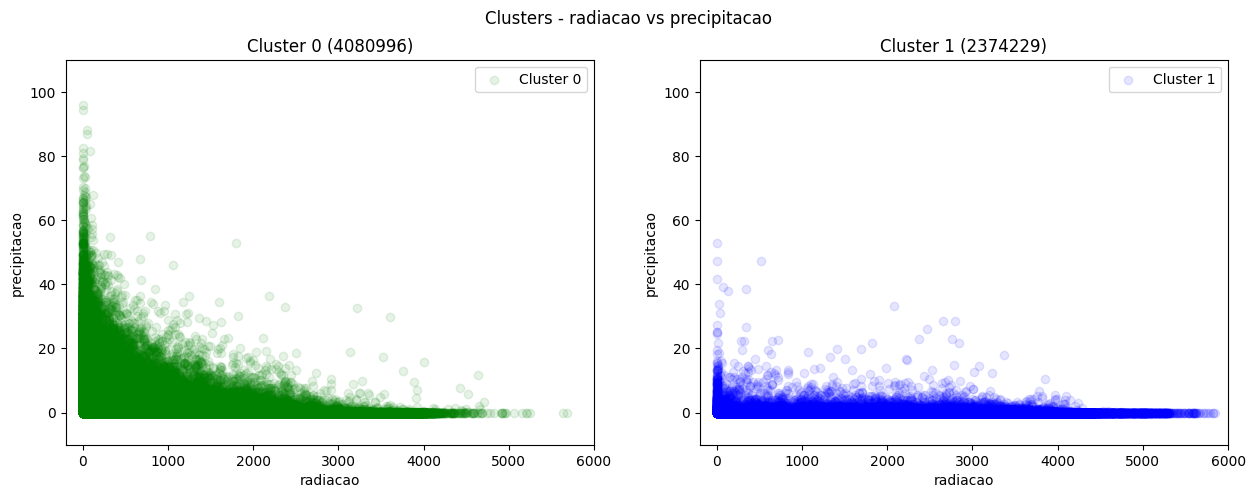

In [10]:
df_c0, df_c1 = clustering_Kmeans(data_model_zero.copy(), ['temperatura', 'umidade'])

#### Step 2.2 - RBFANN

In [456]:
'''variables_to_rbf = ['temperatura', 'umidade', 'pressao_atm']

import pandas as pd
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame loaded earlier
df_rbf = data_model_red.copy()

# Variables for clustering
X = df_rbf[variables_to_rbf].values

# Determine RBF centers using KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
centers = kmeans.cluster_centers_

# Compute the RBF kernel (RBF-transformed data)
gamma = 1.0  # Adjust gamma as needed
G = rbf_kernel(X, centers, gamma=gamma)

# Cluster the RBF-transformed data using MiniBatchKMeans
mini_batch_kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=1000)
df_rbf['Cluster'] = mini_batch_kmeans.fit_predict(G)'''

"variables_to_rbf = ['temperatura', 'umidade', 'pressao_atm']\n\nimport pandas as pd\nfrom sklearn.cluster import KMeans, MiniBatchKMeans\nfrom sklearn.metrics.pairwise import rbf_kernel\nimport matplotlib.pyplot as plt\n\n# Assuming 'data' is your DataFrame loaded earlier\ndf_rbf = data_model_red.copy()\n\n# Variables for clustering\nX = df_rbf[variables_to_rbf].values\n\n# Determine RBF centers using KMeans\nkmeans = KMeans(n_clusters=3, random_state=42)\nkmeans.fit(X)\ncenters = kmeans.cluster_centers_\n\n# Compute the RBF kernel (RBF-transformed data)\ngamma = 1.0  # Adjust gamma as needed\nG = rbf_kernel(X, centers, gamma=gamma)\n\n# Cluster the RBF-transformed data using MiniBatchKMeans\nmini_batch_kmeans = MiniBatchKMeans(n_clusters=3, random_state=42, batch_size=1000)\ndf_rbf['Cluster'] = mini_batch_kmeans.fit_predict(G)"

### Step 3 - Training MLP models

---

#### Step 3.1 - Functions

In [15]:
# Data divide in train (0.8) and test (0.2)

def data_divide(df, variables):

    X = df[variables].values
    y = df.radiacao.values.reshape(-1,1)

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return x_train, y_train, x_test, y_test

In [14]:
# Data normalization

def norm_std(df, variables):

    scaler_lab = StandardScaler()
    scaler_lab.fit(df[variables])
    scaled_features_lab = scaler_lab.transform(df[variables])
    
    data_std = pd.DataFrame(scaled_features_lab, columns=variables, index=df.index)
    
    return data_std, scaler_lab

In [16]:
# Just the metrics

def metricas(rad_medido, rad_calculada):
    MAE = metrics.mean_absolute_error(rad_medido, rad_calculada)
    MSE = metrics.mean_squared_error(rad_medido, rad_calculada)
    RMSE = np.sqrt(metrics.mean_squared_error(rad_medido, rad_calculada))
    R2 = metrics.r2_score(rad_medido, rad_calculada)

    print('Mean Absolute Error:', MAE)
    print('Mean Squared Error:', MSE)
    print('Root Mean Squared Error:', RMSE)
    print('R2 Score:', R2)

In [17]:
# Function of optimization

def grid_search_cv_model(model, x_train, y_train, x_test, y_test, parameters_grid, filename=None):

    grid_search = GridSearchCV(estimator=model, param_grid=parameters_grid, scoring='neg_mean_squared_error', cv=10)

    grid_search.fit(x_train, y_train)

    best_parameters = grid_search.best_params_

    performance = grid_search.score(x_test, y_test)

    print("Best parameters:", best_parameters)
    print("Performance:", performance)

    print('-'*60)
    cvres = grid_search.cv_results_
    for mean_score, parameters_grid in zip(cvres["mean_test_score"], cvres["params"]):
        print(np.sqrt(-mean_score), parameters_grid)

    result_grid_search_cv = pd.DataFrame(grid_search.cv_results_)

    if filename is not None:
        result_grid_search_cv.to_csv(filename, index=False)

#### Step 3.2 - Data preparation

In [18]:
# Variables

variables_without_radiacao = ['hora', 'temperatura', 'umidade']

variables_mlp = ['radiacao', 'hora', 'temperatura', 'umidade']

# All data

df_to_mlp = pd.DataFrame({'radiacao': data_model_red['radiacao'],
                              'hora': data_model_red['hora'],
                              'temperatura': data_model_red['temperatura'],
                              'umidade': data_model_red['umidade']})

df_to_mlp_std, scaler_lab_df_to_mlp_std = norm_std(df_to_mlp, variables_mlp)

x_train_df_to_mlp_std, \
    y_train_df_to_mlp_std, \
        x_test_df_to_mlp_std, \
            y_test_df_to_mlp_std = data_divide(df_to_mlp_std, variables_without_radiacao)

# Cluster 0

df_c0_to_mlp = pd.DataFrame({'radiacao': df_c0['radiacao'],
                             'hora': df_c0['hora'],
                             'temperatura': df_c0['temperatura'],
                             'umidade': df_c0['umidade']})

df_c0_to_mlp_std, scaler_lab_df_c0_to_mlp_std = norm_std(df_c0_to_mlp, variables_mlp)

x_train_df_c0_to_mlp_std, \
    y_train_df_c0_to_mlp_std, \
        x_test_df_c0_to_mlp_std, \
            y_test_df_c0_to_mlp_std = data_divide(df_c0_to_mlp_std, variables_without_radiacao)

# Cluster 1

df_c1_to_mlp = pd.DataFrame({'radiacao': df_c1['radiacao'],
                             'hora': df_c1['hora'],
                             'temperatura': df_c1['temperatura'],
                             'umidade': df_c1['umidade']})

df_c1_to_mlp_std, scaler_lab_df_c1_to_mlp_std = norm_std(df_c1_to_mlp, variables_mlp)

x_train_df_c1_to_mlp_std, \
    y_train_df_c1_to_mlp_std, \
        x_test_df_c1_to_mlp_std, \
            y_test_df_c1_to_mlp_std = data_divide(df_c1_to_mlp_std, variables_without_radiacao)

#### Step 3.3 - Training Models

In [479]:
parameters_grid_mlpr = {
    'hidden_layer_sizes': [(10, 10), 
                           (10, 20), 
                           (10, 30), 
                           (10, 40),
                           (10, 50),
                           (50, 50),
                           (50, 75),
                           (50, 100),
                           (10, 10, 10), 
                           (10, 20, 20), 
                           (10, 20, 30), 
                           (10, 30, 30), 
                           (10, 25, 50), 
                           (10, 50, 10), 
                           (10, 100, 10)],
    'activation': ['relu'], 
    'solver': ['adam'],
    'random_state': [42]
}

All Data model

In [480]:
grid_search_cv_model(MLPRegressor(), \
                     x_train_df_to_mlp_std, \
                     y_train_df_to_mlp_std, \
                     x_test_df_to_mlp_std, \
                     y_test_df_to_mlp_std, \
                     parameters_grid_mlpr, \
                     None)

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 25, 50), 'random_state': 42, 'solver': 'adam'}
Performance: -0.23948781788848839
------------------------------------------------------------
0.49060397925425553 {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'random_state': 42, 'solver': 'adam'}
0.4899240044932533 {'activation': 'relu', 'hidden_layer_sizes': (10, 20), 'random_state': 42, 'solver': 'adam'}
0.4892607830673176 {'activation': 'relu', 'hidden_layer_sizes': (10, 30), 'random_state': 42, 'solver': 'adam'}
0.4898752975156706 {'activation': 'relu', 'hidden_layer_sizes': (10, 40), 'random_state': 42, 'solver': 'adam'}
0.48928624714649066 {'activation': 'relu', 'hidden_layer_sizes': (10, 50), 'random_state': 42, 'solver': 'adam'}
0.48894938347970823 {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'random_state': 42, 'solver': 'adam'}
0.48918086944938355 {'activation': 'relu', 'hidden_layer_sizes': (50, 75), 'random_state': 42, 'solver': 'adam'}
0.4

In [458]:
model_all_data = MLPRegressor(hidden_layer_sizes=(60, 30), activation='relu', solver='adam', random_state=42)

model_all_data.fit(x_train_df_to_mlp_std, y_train_df_to_mlp_std)

MLPRegressor(hidden_layer_sizes=(60, 30), random_state=42)

In [473]:
print('='*60)
print('Training data')
df_model_train = model_test(model_all_data, x_train_df_to_mlp_std, y_train_df_to_mlp_std)

print('='*60)
print('Testing data')
model_test = model_test(model_all_data, x_test_df_to_mlp_std, y_test_df_to_mlp_std)

Training data
------------------------------------------------------------
Mean Absolute Error: 0.35545713701383486
Mean Squared Error: 0.23886617837720575
Root Mean Squared Error: 0.4887393767410252
R2 Score: 0.7611686253713664
Testing data
------------------------------------------------------------
Mean Absolute Error: 0.35537202193457534
Mean Squared Error: 0.2381008703010754
Root Mean Squared Error: 0.4879558077337285
R2 Score: 0.7617602251018647


Cluster 0 model

In [481]:
grid_search_cv_model(MLPRegressor(), \
                     x_train_df_c0_to_mlp_std, \
                     y_train_df_c0_to_mlp_std, \
                     x_test_df_c0_to_mlp_std, \
                     y_test_df_c0_to_mlp_std, \
                     parameters_grid_mlpr, \
                     None)

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 50, 10), 'random_state': 42, 'solver': 'adam'}
Performance: -0.3862636439911954
------------------------------------------------------------
0.6201407784361571 {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'random_state': 42, 'solver': 'adam'}
0.6195226331134662 {'activation': 'relu', 'hidden_layer_sizes': (10, 20), 'random_state': 42, 'solver': 'adam'}
0.6195540278384979 {'activation': 'relu', 'hidden_layer_sizes': (10, 30), 'random_state': 42, 'solver': 'adam'}
0.6194417023875062 {'activation': 'relu', 'hidden_layer_sizes': (10, 40), 'random_state': 42, 'solver': 'adam'}
0.6196840595985293 {'activation': 'relu', 'hidden_layer_sizes': (10, 50), 'random_state': 42, 'solver': 'adam'}
0.6200051254109111 {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'random_state': 42, 'solver': 'adam'}
0.6195488056457171 {'activation': 'relu', 'hidden_layer_sizes': (50, 75), 'random_state': 42, 'solver': 'adam'}
0.619410

In [393]:
model_c0 = MLPRegressor(hidden_layer_sizes=(10, 30, 30), activation='relu', solver='adam', random_state=42)

model_c0.fit(x_train_df_c0_to_mlp_std, y_train_df_c0_to_mlp_std)

MLPRegressor(hidden_layer_sizes=(10, 30, 30), random_state=42)

In [474]:
print('='*60)
print('Training data')
df_model_c0_train = model_test(model_c0, x_train_df_c0_to_mlp_std, y_train_df_c0_to_mlp_std)

print('='*60)
print('Testing data')
df_model_c0_test = model_test(model_c0, x_test_df_c0_to_mlp_std, y_test_df_c0_to_mlp_std)

Training data


TypeError: 'DataFrame' object is not callable

Cluster 1 model

In [482]:
grid_search_cv_model(MLPRegressor(), \
                     x_train_df_c1_to_mlp_std, \
                     y_train_df_c1_to_mlp_std, \
                     x_test_df_c1_to_mlp_std, \
                     y_test_df_c1_to_mlp_std, \
                     parameters_grid_mlpr, \
                     None)

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 30, 30), 'random_state': 42, 'solver': 'adam'}
Performance: -0.2857966363995748
------------------------------------------------------------
0.5337687100444368 {'activation': 'relu', 'hidden_layer_sizes': (10, 10), 'random_state': 42, 'solver': 'adam'}
0.5338721497713018 {'activation': 'relu', 'hidden_layer_sizes': (10, 20), 'random_state': 42, 'solver': 'adam'}
0.5336373637396274 {'activation': 'relu', 'hidden_layer_sizes': (10, 30), 'random_state': 42, 'solver': 'adam'}
0.5331816499518356 {'activation': 'relu', 'hidden_layer_sizes': (10, 40), 'random_state': 42, 'solver': 'adam'}
0.5334267754155684 {'activation': 'relu', 'hidden_layer_sizes': (10, 50), 'random_state': 42, 'solver': 'adam'}
0.5334569774963652 {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'random_state': 42, 'solver': 'adam'}
0.5330038589802267 {'activation': 'relu', 'hidden_layer_sizes': (50, 75), 'random_state': 42, 'solver': 'adam'}
0.532937

In [395]:
model_c1 = MLPRegressor(hidden_layer_sizes=(10, 25, 50), activation='relu', solver='adam', random_state=42)

model_c1.fit(x_train_df_c1_to_mlp_std, y_train_df_c1_to_mlp_std)

MLPRegressor(hidden_layer_sizes=(10, 25, 50), random_state=42)

In [396]:
print('='*60)
print('Training data')
df_model_c1_train = model_test(model_c1, x_train_df_c1_to_mlp_std, y_train_df_c1_to_mlp_std)

print('='*60)
print('Testing data')
df_model_c1_test = model_test(model_c1, x_test_df_c1_to_mlp_std, y_test_df_c1_to_mlp_std)

Training data
------------------------------------------------------------
Mean Absolute Error: 0.3902220893801799
Mean Squared Error: 0.28480460281193787
Root Mean Squared Error: 0.5336708749893869
R2 Score: 0.7149576035739045
Testing data
------------------------------------------------------------
Mean Absolute Error: 0.3916677964769661
Mean Squared Error: 0.2873874575375045
Root Mean Squared Error: 0.536085308078392
R2 Score: 0.7135668272754421


### Step 4 - Checking MLP models with Prototype data

---

#### Step 4.1 - Data preparation

In [12]:
data_prototype = pd.read_csv(r'H:\Meu Drive\code\2_Prototipo_TCC\data_TCC_prototipo.csv', delimiter=",")
data_prototype['data'] = pd.to_datetime(data_prototype['data'])

'''sd = '2024-03-10'
ed = '2024-05-04'
data_prototype = data_prototype.query('data >= @sd and data <= @ed')
'''
display(data_prototype)

data_prototype.info()

data  hora  temperatura    umidade  radiacao_medido  \
0    2024-03-09     8       30.975  62.250000          511.825   
1    2024-03-09     9       32.500  57.075000         1375.575   
2    2024-03-09    10       32.000  59.575000         2294.825   
3    2024-03-09    11       31.650  60.050000         2939.650   
4    2024-03-09    12       31.525  58.550000         3174.175   
...         ...   ...          ...        ...              ...   
1319 2024-05-05    17       30.125  39.950000          841.300   
1320 2024-05-05    18       29.450  41.750000          126.925   
1321 2024-05-05    19       29.225  41.850000            0.000   
1322 2024-05-05    20       29.050  41.725000            0.000   
1323 2024-05-05    21       28.800  42.133333            0.000   

      precipitacao_medido  
0                    0.00  
1                    0.00  
2                    0.00  
3                    0.00  
4                    0.05  
...                   ...  
1319                 0.00  
1320                 0.00  
1321                 0.00  
1322                 0.00  
1323                 0.00  

[1324 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   data                 1324 non-null   datetime64[ns]
 1   hora                 1324 non-null   int64         
 2   temperatura          1324 non-null   float64       
 3   umidade              1324 non-null   float64       
 4   radiacao_medido      1324 non-null   float64       
 5   precipitacao_medido  1324 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 62.2 KB


Data Normalization

In [13]:
data_prototype_to_mlp = pd.DataFrame({'hora': data_prototype['hora'],
                                      'temperatura': data_prototype['temperatura'],
                                      'umidade': data_prototype['umidade'],
                                      'radiacao_medido': data_prototype['radiacao_medido'],
                                      'precipitacao_medido': data_prototype['precipitacao_medido']})

variables_prototype_to_mlp = ['hora', 'temperatura', 'umidade', 'radiacao_medido', 'precipitacao_medido']

data_prototype_to_mlp_std, scaler_lab_data_prototype_to_mlp_std = norm_std(data_prototype_to_mlp, variables_prototype_to_mlp)

# Scatter plot of target variable 'radiacao' by 'hora'

ax = data_prototype_to_mlp_std.plot(kind="scatter", x="hora", y="radiacao_medido", alpha=0.5)
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel("hora", fontsize=14)
ax.set_ylabel("irradiação (Kj/m2)", fontsize=14) 

NameError: name 'norm_std' is not defined

#### Step 4.2 - Target estimation

In [460]:
data_prototype_calc = data_prototype_to_mlp_std.copy()

# Model All Data
radiacao_calc_all = model_all_data.predict(pd.DataFrame({'hora': data_prototype_calc['hora'],
                                                       'temperatura': data_prototype_calc['temperatura'], 
                                                       'umidade': data_prototype_calc['umidade']}))

radiacao_calc_all = pd.Series(radiacao_calc_all)

data_prototype_calc['radiacao_calc_all'] = radiacao_calc_all

# Model C0
radiacao_calc_c0 = model_c0.predict(pd.DataFrame({'hora': data_prototype_calc['hora'],
                                                  'temperatura': data_prototype_calc['temperatura'], 
                                                  'umidade': data_prototype_calc['umidade']}))

radiacao_calc_c0 = pd.Series(radiacao_calc_c0)

data_prototype_calc['radiacao_calc_c0'] = radiacao_calc_c0

# Model C1
radiacao_calc_c1 = model_c1.predict(pd.DataFrame({'hora': data_prototype_calc['hora'],
                                                  'temperatura': data_prototype_calc['temperatura'], 
                                                  'umidade': data_prototype_calc['umidade']}))

radiacao_calc_c1 = pd.Series(radiacao_calc_c1)

data_prototype_calc['radiacao_calc_c1'] = radiacao_calc_c1

display(data_prototype_calc)

hora  temperatura   umidade  radiacao_medido  precipitacao_medido  \
0    -0.517402     1.391281 -0.187000        -0.216154            -0.116199   
1    -0.372205     1.812203 -0.698505         0.658982            -0.116199   
2    -0.227008     1.674196 -0.451401         1.590350            -0.116199   
3    -0.081811     1.577591 -0.404452         2.243675            -0.116199   
4     0.063387     1.543089 -0.552714         2.481292            -0.082598   
...        ...          ...       ...              ...                  ...   
1319  0.789373     1.156669 -2.391164         0.117664            -0.116199   
1320  0.934570     0.970359 -2.213249        -0.606128            -0.116199   
1321  1.079767     0.908256 -2.203365        -0.734726            -0.116199   
1322  1.224965     0.859953 -2.215720        -0.734726            -0.116199   
1323  1.370162     0.790950 -2.175360        -0.734726            -0.116199   

      radiacao_calc_all  radiacao_calc_c0  radiacao_calc_c1  
0              0.823671          1.104300          0.542636  
1              1.147577          1.152984          1.022382  
2              1.323423          1.183970          1.204159  
3              1.488333          1.179160          1.275554  
4              1.581548          1.141517          1.435927  
...                 ...               ...               ...  
1319           0.917489         -0.108032          1.799529  
1320           0.660860         -0.369236          1.650771  
1321           0.377026         -0.600231          1.446895  
1322           0.097876         -0.827931          1.236617  
1323          -0.186210         -1.102720          0.984280  

[1324 rows x 8 columns]

#### Step 4.3 - Metrics and Plot

In [461]:
metricas(data_prototype_calc['radiacao_medido'], data_prototype_calc['radiacao_calc_all'])

Mean Absolute Error: 0.5418055750762801
Mean Squared Error: 0.431375990346829
Root Mean Squared Error: 0.6567921972335155
R2 Score: 0.568624009653171


In [462]:
metricas(data_prototype_calc['radiacao_medido'], data_prototype_calc['radiacao_calc_c0'])

Mean Absolute Error: 0.6088266529473899
Mean Squared Error: 0.5613975408414202
Root Mean Squared Error: 0.7492646667509554
R2 Score: 0.43860245915857965


In [465]:
metricas(data_prototype_calc['radiacao_medido'], data_prototype_calc['radiacao_calc_c1'])

Mean Absolute Error: 0.6163268292052609
Mean Squared Error: 0.6330250573552128
Root Mean Squared Error: 0.7956287182820971
R2 Score: 0.36697494264478714


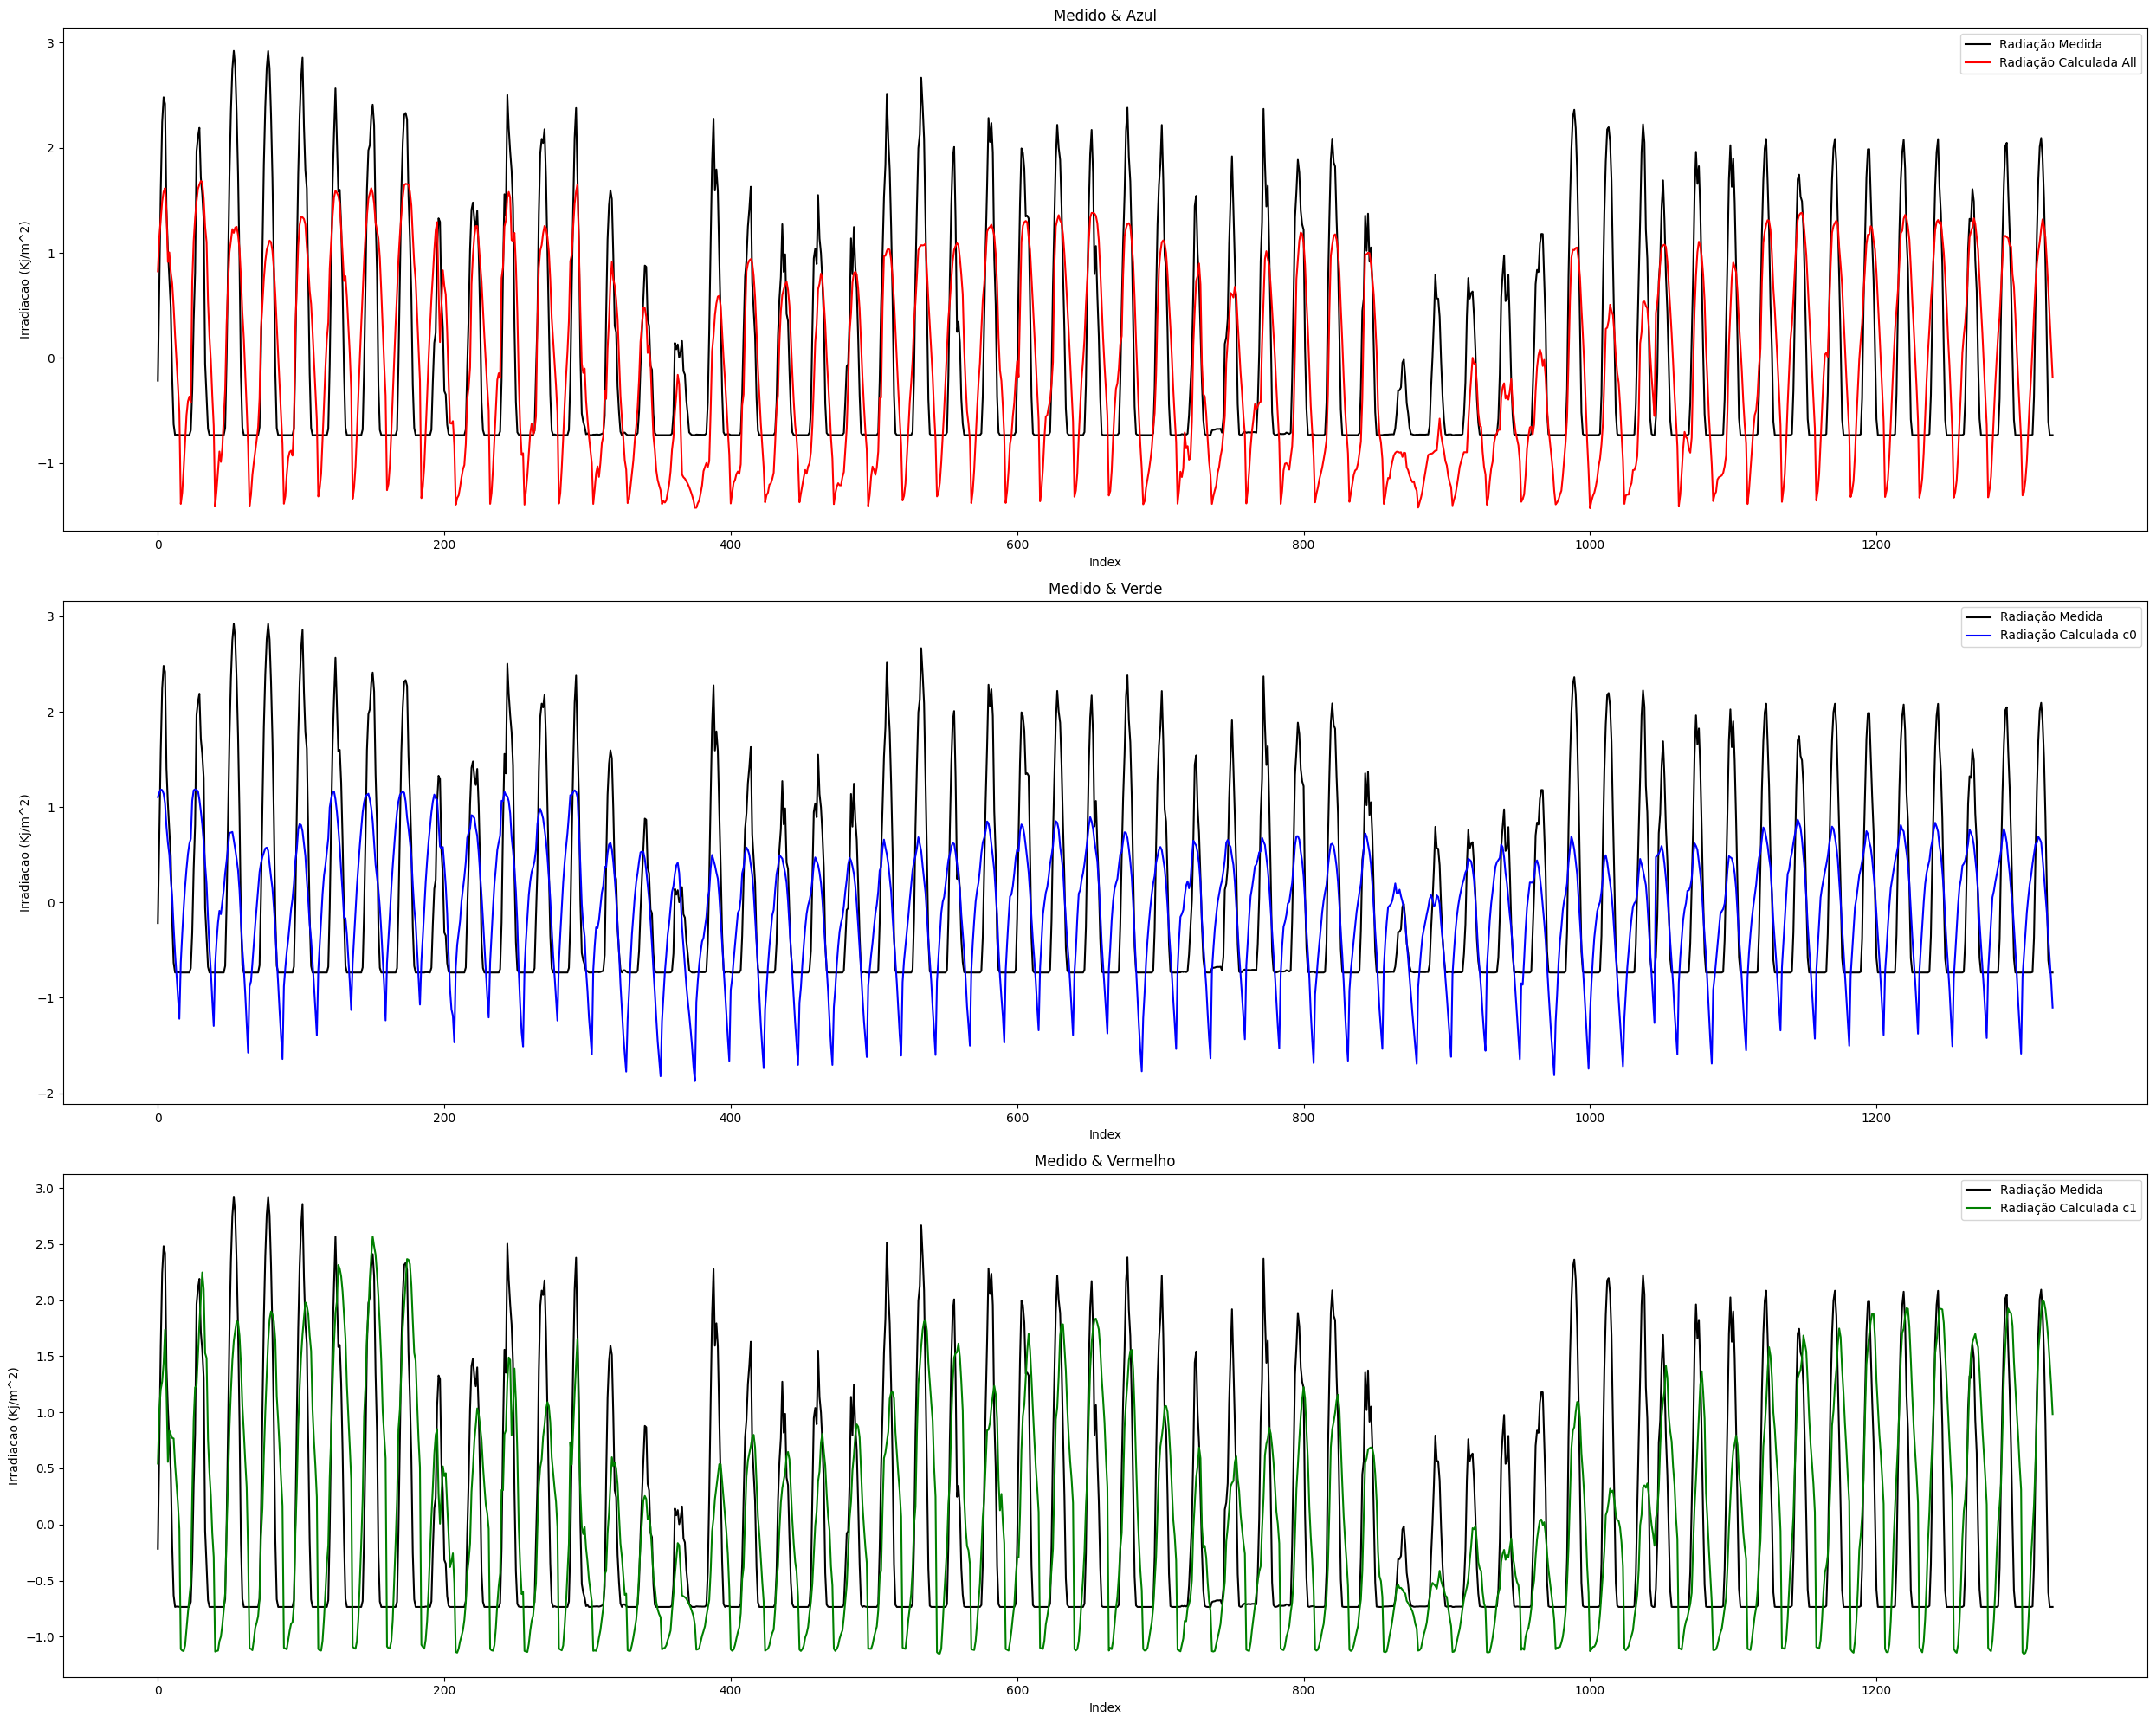

In [466]:
# Plotting the data
fig, axs = plt.subplots(3, 1, figsize=(25, 20))

axs[0].plot(data_prototype_calc.index, data_prototype_calc['radiacao_medido'], color='black', label='Radiação Medida')
axs[0].plot(data_prototype_calc.index, data_prototype_calc['radiacao_calc_all'], color='red', label='Radiação Calculada All')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Irradiacao (Kj/m^2)')
axs[0].set_title('Medido & Azul')
axs[0].legend()
axs[0].grid(False)

axs[1].plot(data_prototype_calc.index, data_prototype_calc['radiacao_medido'], color='black', label='Radiação Medida')
axs[1].plot(data_prototype_calc.index, data_prototype_calc['radiacao_calc_c0'], color='blue', label='Radiação Calculada c0')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Irradiacao (Kj/m^2)')
axs[1].set_title('Medido & Verde')
axs[1].legend()
axs[1].grid(False)

axs[2].plot(data_prototype_calc.index, data_prototype_calc['radiacao_medido'], color='black', label='Radiação Medida')
axs[2].plot(data_prototype_calc.index, data_prototype_calc['radiacao_calc_c1'], color='green', label='Radiação Calculada c1')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Irradiacao (Kj/m^2)')
axs[2].set_title('Medido & Vermelho')
axs[2].legend()
axs[2].grid(False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

---
---

In [11]:
def app(df, df_prop, config):
    
    # clustering #####################################################################################################
    print('-'*50)
    print('Clustering Process')
    print('-'*50)

    df_c0, df_c1 = clustering_Kmeans(df.copy(), ['temperatura', 'umidade'])

    '''    if config == 'ab':
        print('Cluster 0 - Less Humidity')
        # df_c0 = df_c0
        print('Cluster 1 - More Humidity')
        # df_c1 = df_c1

    if config == 'ba':
        print('Cluster 0 - More Humidity')
        # df_c0 = df_c1
        print('Cluster 1 - Less Humidity')
        # df_c1 = df_c0

        df_troca = df_c0.copy()

        df_c0 = df_c1.copy()
        df_c1 = df_troca.copy()'''

    print('[OK]')
    # Data preparation #####################################################################################################
    print('-'*50)
    print('Data Preparation')
    print('-'*50)

    variables_without_radiacao = ['hora', 'temperatura', 'umidade']
    variables_mlp = ['radiacao', 'hora', 'temperatura', 'umidade']

    df_to_mlp = pd.DataFrame({'radiacao': df['radiacao'],
                                'hora': df['hora'],
                                'temperatura': df['temperatura'],
                                'umidade': df['umidade']})
    df_to_mlp_std, scaler_lab_df_to_mlp_std = norm_std(df_to_mlp, variables_mlp)
    x_train_df_to_mlp_std, \
        y_train_df_to_mlp_std, \
            x_test_df_to_mlp_std, \
                y_test_df_to_mlp_std = data_divide(df_to_mlp_std, variables_without_radiacao)

    df_c0_to_mlp = pd.DataFrame({'radiacao': df_c0['radiacao'],
                                'hora': df_c0['hora'],
                                'temperatura': df_c0['temperatura'],
                                'umidade': df_c0['umidade']})
    df_c0_to_mlp_std, scaler_lab_df_c0_to_mlp_std = norm_std(df_c0_to_mlp, variables_mlp)
    x_train_df_c0_to_mlp_std, \
        y_train_df_c0_to_mlp_std, \
            x_test_df_c0_to_mlp_std, \
                y_test_df_c0_to_mlp_std = data_divide(df_c0_to_mlp_std, variables_without_radiacao)

    df_c1_to_mlp = pd.DataFrame({'radiacao': df_c1['radiacao'],
                                'hora': df_c1['hora'],
                                'temperatura': df_c1['temperatura'],
                                'umidade': df_c1['umidade']})
    df_c1_to_mlp_std, scaler_lab_df_c1_to_mlp_std = norm_std(df_c1_to_mlp, variables_mlp)
    x_train_df_c1_to_mlp_std, \
        y_train_df_c1_to_mlp_std, \
            x_test_df_c1_to_mlp_std, \
                y_test_df_c1_to_mlp_std = data_divide(df_c1_to_mlp_std, variables_without_radiacao)
    
    print('[OK]')
    # Training models #####################################################################################################
    print('-'*50)
    print('Training Models')
    print('-'*50)

    data_model_calc = pd.DataFrame()

    print('\n All data [...]')
    model_all_data = MLPRegressor(hidden_layer_sizes=(10, 25, 50), activation='relu', solver='adam', random_state=42)
    model_all_data.fit(x_train_df_to_mlp_std, y_train_df_to_mlp_std)
    print('Training metrics')
    metricas(pd.Series(y_train_df_to_mlp_std.ravel()), pd.Series(model_all_data.predict(pd.DataFrame(x_train_df_to_mlp_std))))
    print('Test metrics')
    metricas(pd.Series(y_test_df_to_mlp_std.ravel()), pd.Series(model_all_data.predict(pd.DataFrame(x_test_df_to_mlp_std))))

    print('\n Cluster 0 [...] - More Humidity')
    model_c0 = MLPRegressor(hidden_layer_sizes=(10, 30, 30), activation='relu', solver='adam', random_state=42)
    model_c0.fit(x_train_df_c0_to_mlp_std, y_train_df_c0_to_mlp_std)
    print('Training metrics')
    metricas(pd.Series(y_train_df_c0_to_mlp_std.ravel()), pd.Series(model_c0.predict(pd.DataFrame(x_train_df_c0_to_mlp_std))))
    print('Test metrics')
    metricas(pd.Series(y_test_df_c0_to_mlp_std.ravel()), pd.Series(model_c0.predict(pd.DataFrame(x_test_df_c0_to_mlp_std))))

    print('\n Cluster 1 [...] - Less Humidity')
    model_c1 = MLPRegressor(hidden_layer_sizes=(10, 50, 10), activation='relu', solver='adam', random_state=42)
    model_c1.fit(x_train_df_c1_to_mlp_std, y_train_df_c1_to_mlp_std)
    print('Training metrics')
    metricas(pd.Series(y_train_df_c1_to_mlp_std.ravel()), pd.Series(model_c1.predict(pd.DataFrame(x_train_df_c1_to_mlp_std))))
    print('Test metrics')
    metricas(pd.Series(y_test_df_c1_to_mlp_std.ravel()), pd.Series(model_c1.predict(pd.DataFrame(x_test_df_c1_to_mlp_std))))

    print('[OK]')
    # Target estimation #####################################################################################################
    print('-'*50)
    print('Target Estimation with Prototype Data')
    print('-'*50)

    data_prototype_calc = df_prop.copy()

    data_prototype_calc = pd.DataFrame({'hora': data_prototype['hora'],
                                        'temperatura': data_prototype['temperatura'],
                                        'umidade': data_prototype['umidade'],
                                        'radiacao_medido': data_prototype['radiacao_medido'],
                                        'precipitacao_medido': data_prototype['precipitacao_medido']})

    variables_prototype_to_mlp = ['hora', 'temperatura', 'umidade', 'radiacao_medido', 'precipitacao_medido']

    data_prototype_calc, scaler_lab_data_prototype_to_mlp_std = norm_std(data_prototype_calc, variables_prototype_to_mlp)

    radiacao_calc_all = model_all_data.predict(pd.DataFrame({'hora': data_prototype_calc['hora'],
                                                        'temperatura': data_prototype_calc['temperatura'], 
                                                        'umidade': data_prototype_calc['umidade']}))
    radiacao_calc_all = pd.Series(radiacao_calc_all)
    data_prototype_calc['radiacao_calc_all'] = radiacao_calc_all

    radiacao_calc_c0 = model_c0.predict(pd.DataFrame({'hora': data_prototype_calc['hora'],
                                                    'temperatura': data_prototype_calc['temperatura'], 
                                                    'umidade': data_prototype_calc['umidade']}))
    radiacao_calc_c0 = pd.Series(radiacao_calc_c0)
    data_prototype_calc['radiacao_calc_c0'] = radiacao_calc_c0

    radiacao_calc_c1 = model_c1.predict(pd.DataFrame({'hora': data_prototype_calc['hora'],
                                                    'temperatura': data_prototype_calc['temperatura'], 
                                                    'umidade': data_prototype_calc['umidade']}))
    radiacao_calc_c1 = pd.Series(radiacao_calc_c1)
    data_prototype_calc['radiacao_calc_c1'] = radiacao_calc_c1

    # display(data_prototype_calc)

    print('[OK]')
    # Metrics #####################################################################################################
    print('-'*50)
    print('Metrics value')
    print('-'*50)

    print('\n All data [...]')
    metricas(data_prototype_calc['radiacao_medido'], data_prototype_calc['radiacao_calc_all'])

    print('\n Cluster 0 [...]')
    metricas(data_prototype_calc['radiacao_medido'], data_prototype_calc['radiacao_calc_c0'])

    print('\n Cluster 1 [...]')
    metricas(data_prototype_calc['radiacao_medido'], data_prototype_calc['radiacao_calc_c1'])

    print('[OK]')

    # Desnormalization #####################################################################################################
    print('-'*50)
    print('Desnormalization')
    print('-'*50)

    data_prototype_final = df_prop.copy()

    data_radiacao_medido = data_prototype_final['radiacao_medido'].copy()
    data_radiacao_medido = pd.DataFrame(data_radiacao_medido)
    data_radiacao_medido_reshaped = data_radiacao_medido['radiacao_medido'].values.reshape(-1, 1)

    scaler_lab = StandardScaler()
    scaler_lab.fit(data_radiacao_medido_reshaped)

    # All data
    data_prototype_final['radiacao_all'] = pd.Series((scaler_lab.inverse_transform(pd.DataFrame(data_prototype_calc['radiacao_calc_all']))).ravel())

    # Cluster 0
    data_prototype_final['radiacao_c0'] = pd.Series((scaler_lab.inverse_transform(pd.DataFrame(data_prototype_calc['radiacao_calc_c0']))).ravel())

    # Cluster 1
    data_prototype_final['radiacao_c1'] = pd.Series((scaler_lab.inverse_transform(pd.DataFrame(data_prototype_calc['radiacao_calc_c1']))).ravel())

    display(data_prototype_final)
    
    print('[OK]')
    # Plot #####################################################################################################
    print('-'*50)
    print('Plot')
    print('-'*50)

    fig, axs = plt.subplots(3, 1, figsize=(25, 20))

    axs[0].plot(data_prototype_final.index, data_prototype_final['radiacao_medido'], color='black', label='Radiação Medida')
    axs[0].plot(data_prototype_final.index, data_prototype_final['radiacao_all'], color='red', label='Radiação Calculada All')
    axs[0].set_xlabel('Index')
    axs[0].set_ylabel('Irradiacao (Kj/m^2)')
    axs[0].legend()
    axs[0].grid(False)

    axs[1].plot(data_prototype_final.index, data_prototype_final['radiacao_medido'], color='black', label='Radiação Medida')
    axs[1].plot(data_prototype_final.index, data_prototype_final['radiacao_c0'], color='green', label='Radiação Calculada c0')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Irradiacao (Kj/m^2)')
    axs[1].legend()
    axs[1].grid(False)

    axs[2].plot(data_prototype_final.index, data_prototype_final['radiacao_medido'], color='black', label='Radiação Medida')
    axs[2].plot(data_prototype_final.index, data_prototype_final['radiacao_c1'], color='blue', label='Radiação Calculada c1')
    axs[2].set_xlabel('Index')
    axs[2].set_ylabel('Irradiacao (Kj/m^2)')
    axs[2].legend()
    axs[2].grid(False)

    plt.tight_layout()
    plt.show()

    print('[OK]')

    return data_prototype_final

In [569]:
data_prototype

data  hora  temperatura    umidade  radiacao_medido  \
0    2024-03-09     8       30.975  62.250000          511.825   
1    2024-03-09     9       32.500  57.075000         1375.575   
2    2024-03-09    10       32.000  59.575000         2294.825   
3    2024-03-09    11       31.650  60.050000         2939.650   
4    2024-03-09    12       31.525  58.550000         3174.175   
...         ...   ...          ...        ...              ...   
1319 2024-05-05    17       30.125  39.950000          841.300   
1320 2024-05-05    18       29.450  41.750000          126.925   
1321 2024-05-05    19       29.225  41.850000            0.000   
1322 2024-05-05    20       29.050  41.725000            0.000   
1323 2024-05-05    21       28.800  42.133333            0.000   

      precipitacao_medido  
0                    0.00  
1                    0.00  
2                    0.00  
3                    0.00  
4                    0.05  
...                   ...  
1319                 0.00  
1320                 0.00  
1321                 0.00  
1322                 0.00  
1323                 0.00  

[1324 rows x 6 columns]

--------------------------------------------------
Clustering Process
--------------------------------------------------


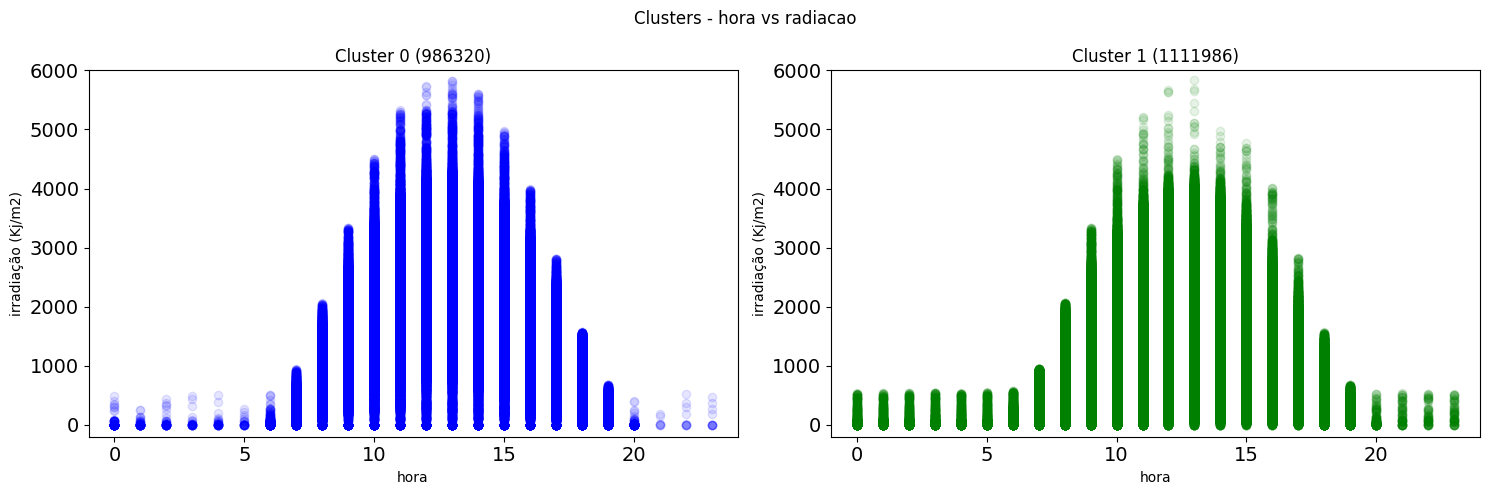

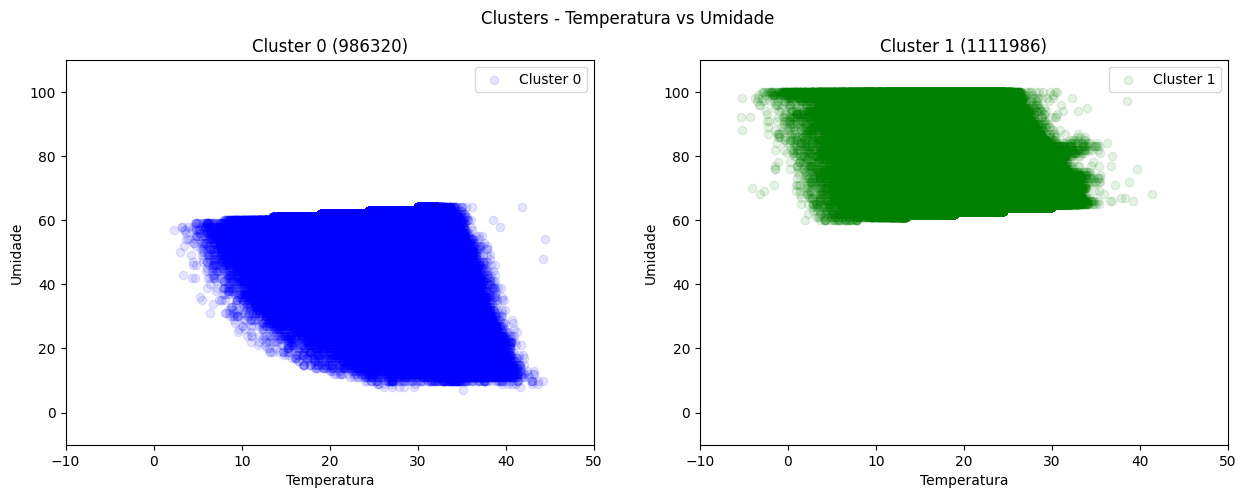

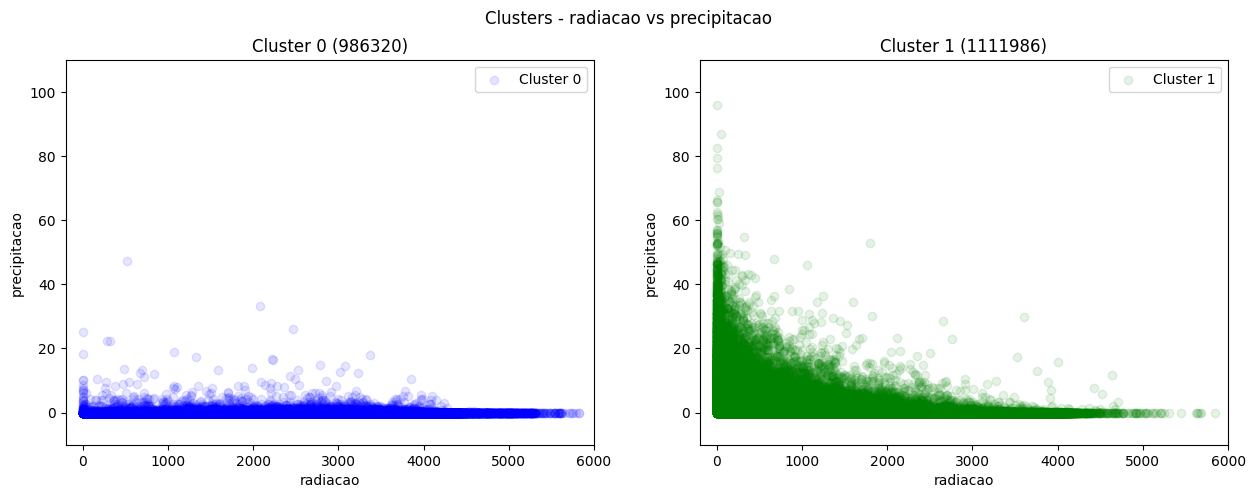

Cluster 0 - Less Humidity
Cluster 1 - More Humidity
[OK]
--------------------------------------------------
Data Preparation
--------------------------------------------------
[OK]
--------------------------------------------------
Training Models
--------------------------------------------------

 All data [...]
Training metrics
Mean Absolute Error: 0.3592038658649624
Mean Squared Error: 0.2403232873662794
Root Mean Squared Error: 0.4902277913034709
R2 Score: 0.7597117286888455
Test metrics
Mean Absolute Error: 0.35902912192067726
Mean Squared Error: 0.23948781788848839
Root Mean Squared Error: 0.48937492568427365
R2 Score: 0.7603724683893296

 Cluster 0 [...] - Less Humidity
Training metrics
Mean Absolute Error: 0.4638125696577549
Mean Squared Error: 0.3832336043697703
Root Mean Squared Error: 0.6190586437243004
R2 Score: 0.6168745330015359
Test metrics
Mean Absolute Error: 0.4652155704568151
Mean Squared Error: 0.3862636439911954
Root Mean Squared Error: 0.6215011214721945
R2 Score

data  hora  temperatura    umidade  radiacao_medido  \
0    2024-03-09     8       30.975  62.250000          511.825   
1    2024-03-09     9       32.500  57.075000         1375.575   
2    2024-03-09    10       32.000  59.575000         2294.825   
3    2024-03-09    11       31.650  60.050000         2939.650   
4    2024-03-09    12       31.525  58.550000         3174.175   
...         ...   ...          ...        ...              ...   
1319 2024-05-05    17       30.125  39.950000          841.300   
1320 2024-05-05    18       29.450  41.750000          126.925   
1321 2024-05-05    19       29.225  41.850000            0.000   
1322 2024-05-05    20       29.050  41.725000            0.000   
1323 2024-05-05    21       28.800  42.133333            0.000   

      precipitacao_medido  radiacao_all  radiacao_c0  radiacao_c1  
0                    0.00   1535.966538  1824.213066  1278.927513  
1                    0.00   1878.081028  1826.002235  1771.044978  
2                    0.00   2056.926365  1850.379325  1957.009656  
3                    0.00   2154.909210  1853.496250  2069.076183  
4                    0.05   2227.892736  1823.075710  2165.393868  
...                   ...           ...          ...          ...  
1319                 0.00   1625.597989   635.810348  2536.440615  
1320                 0.00   1389.566868   396.366224  2255.761166  
1321                 0.00   1194.684408   139.704572  2045.777815  
1322                 0.00    892.232002  -138.652762  1827.897671  
1323                 0.00    595.459957  -411.754312  1599.290734  

[1324 rows x 9 columns]

[OK]
--------------------------------------------------
Plot
--------------------------------------------------


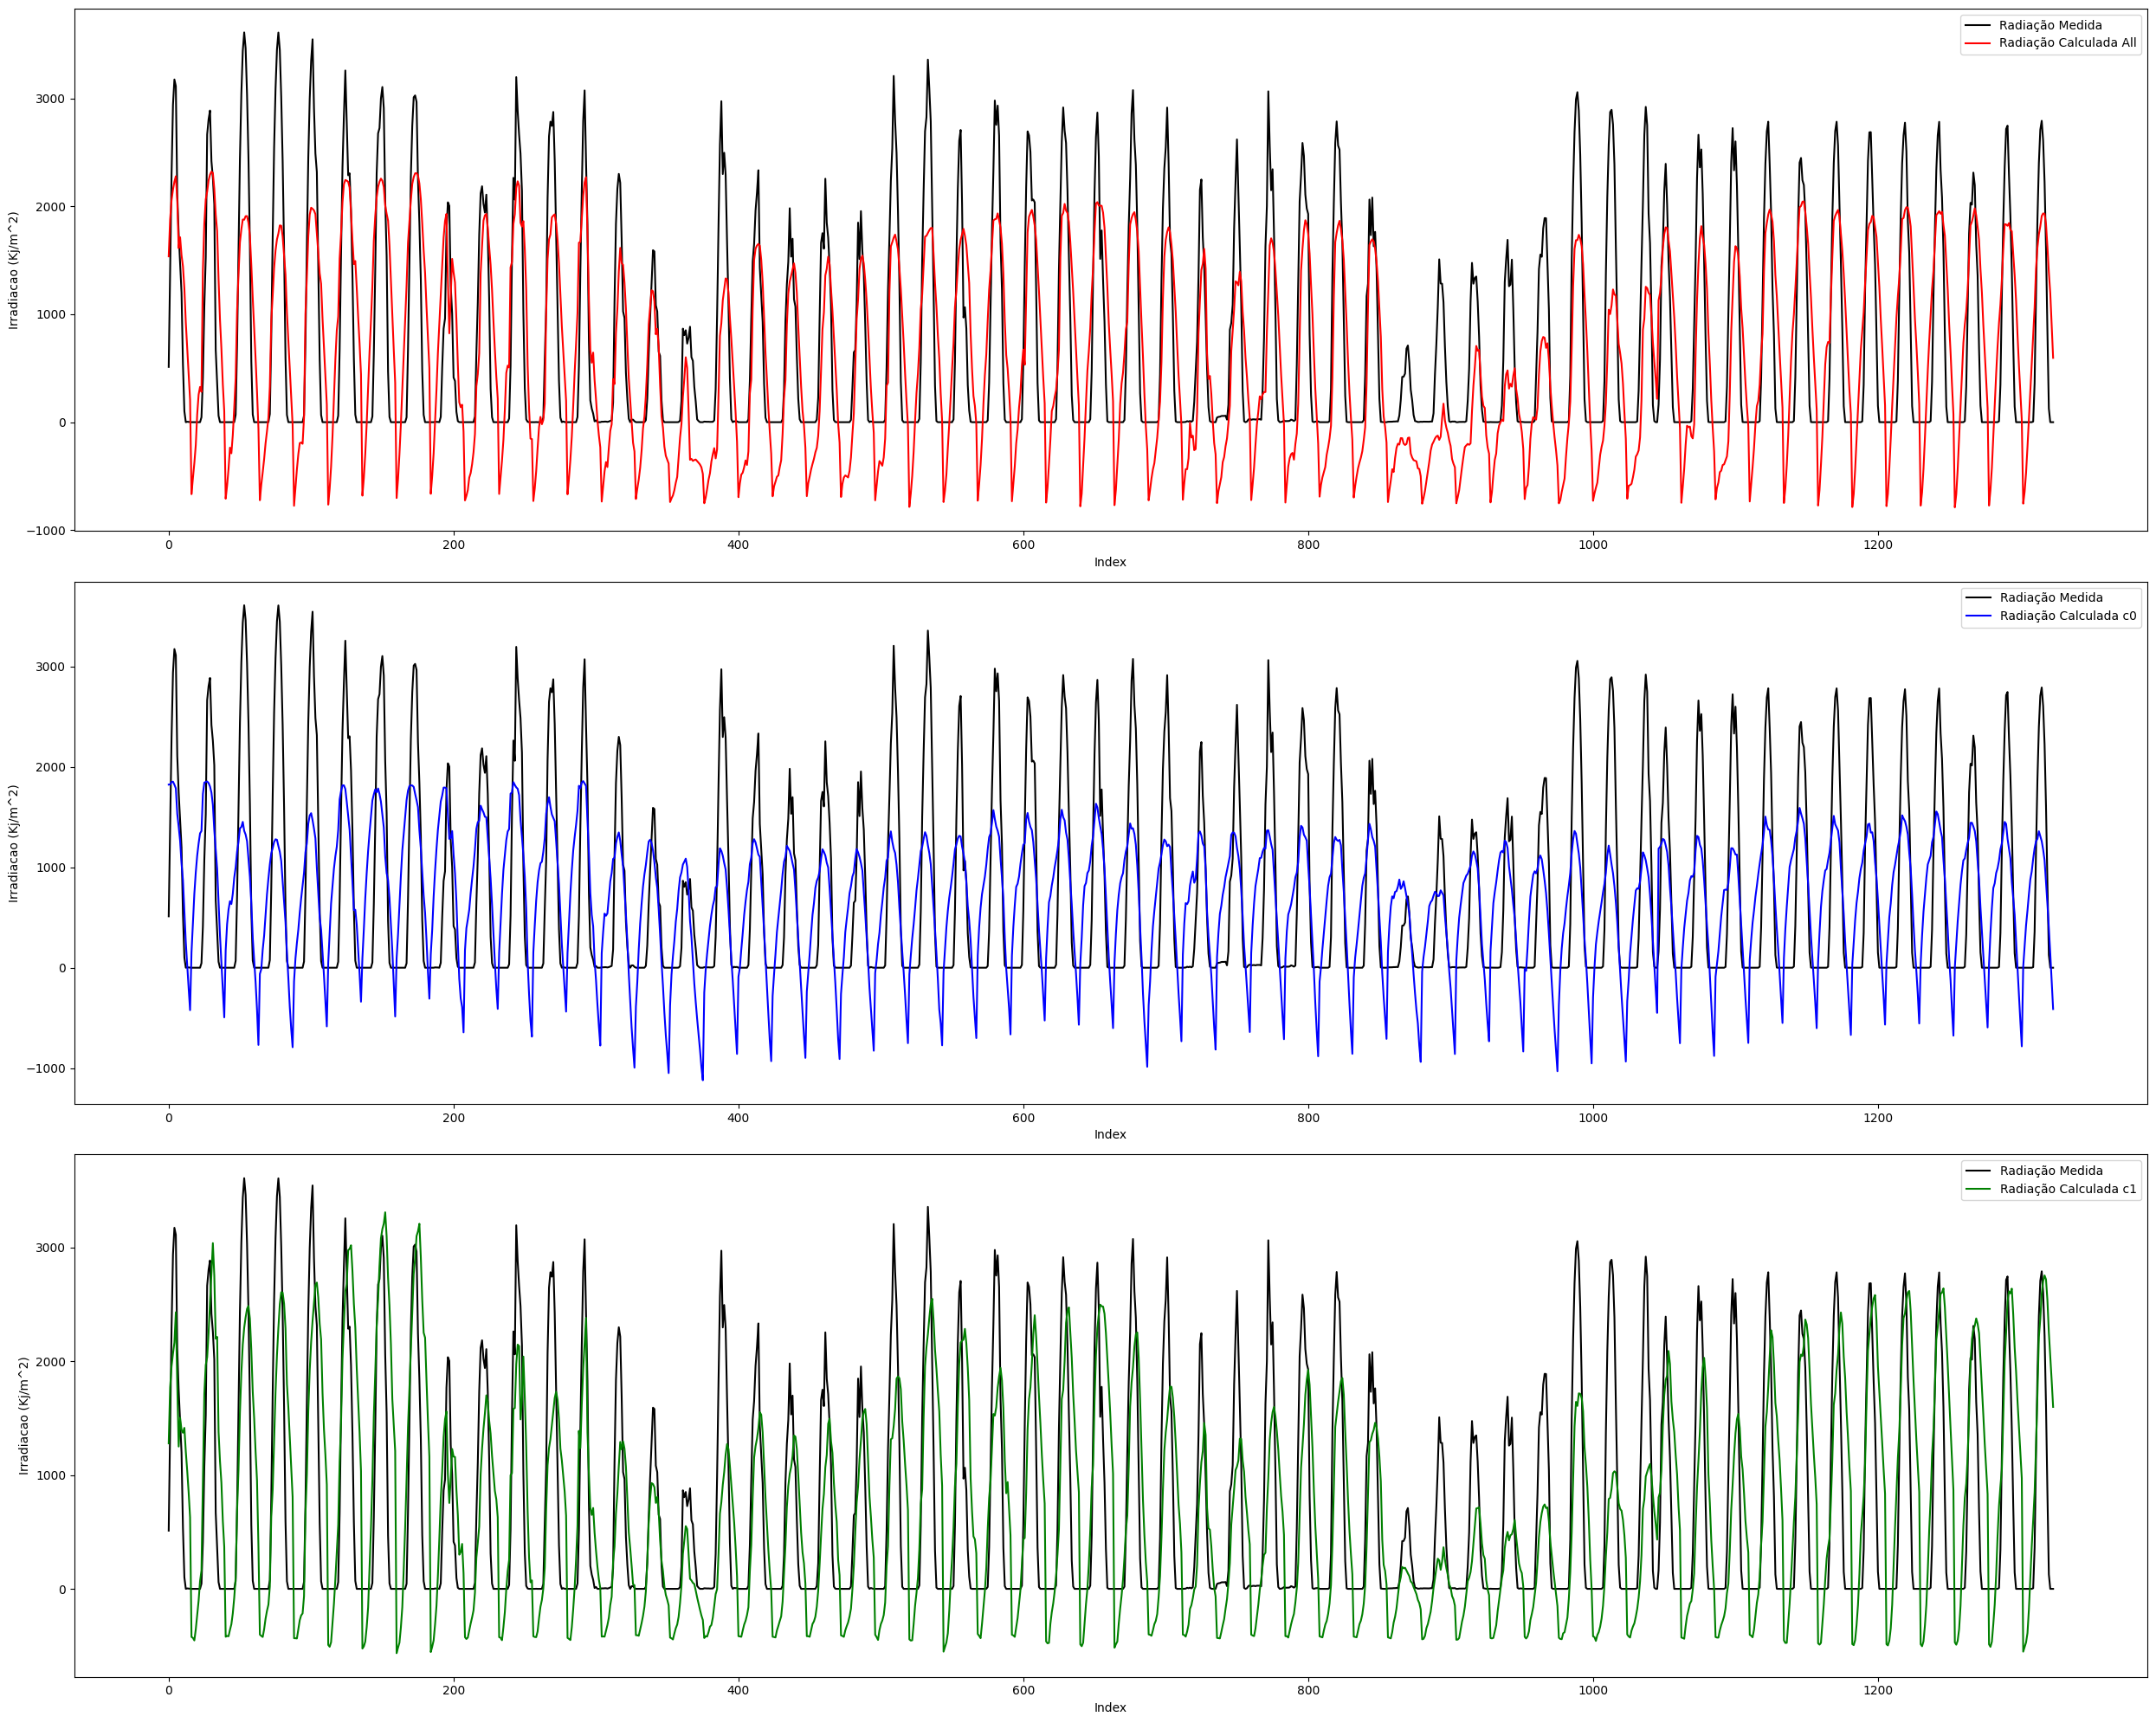

[OK]


In [571]:
data_prototype_final_red = app(data_model_red, data_prototype, 'ab')

--------------------------------------------------
Clustering Process
--------------------------------------------------


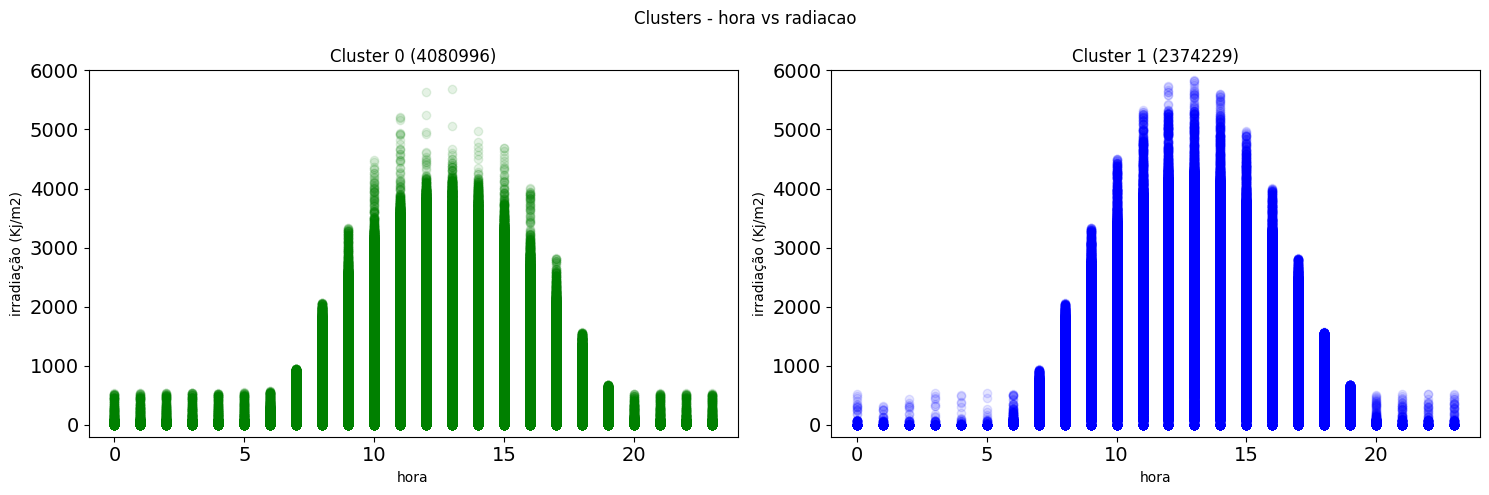

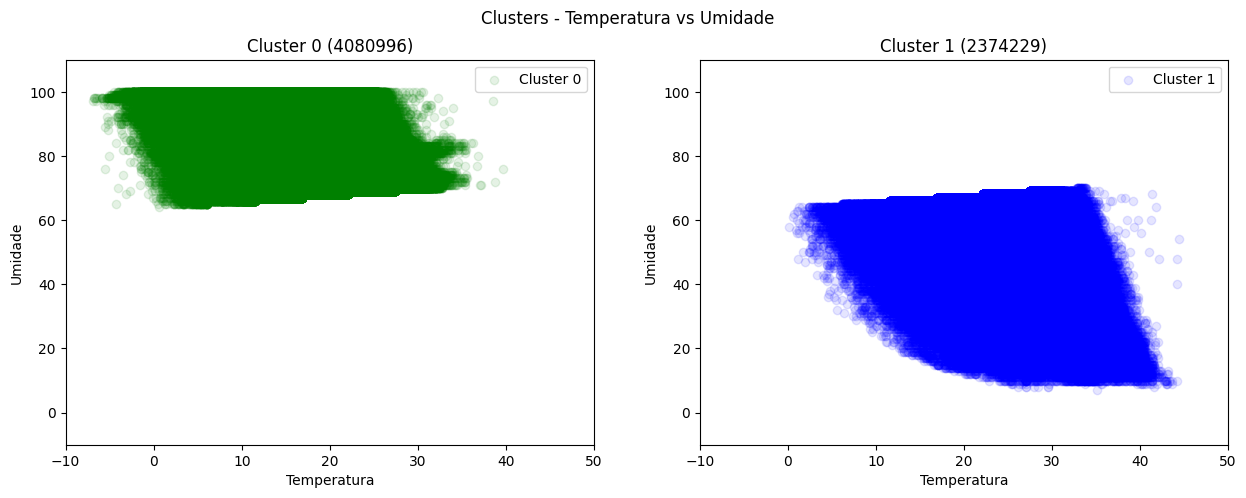

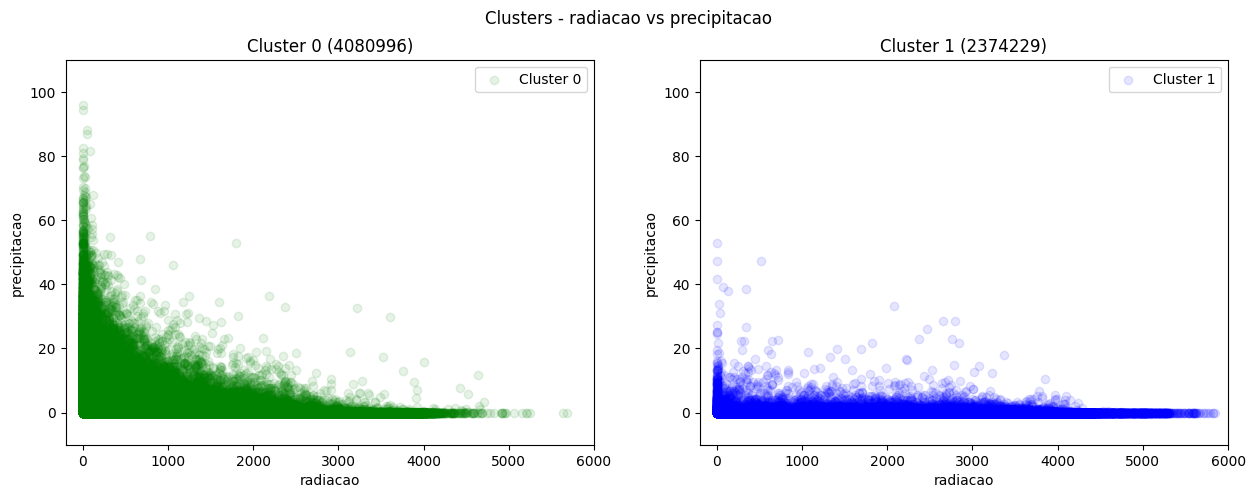

[OK]
--------------------------------------------------
Data Preparation
--------------------------------------------------
[OK]
--------------------------------------------------
Training Models
--------------------------------------------------

 All data [...]
Training metrics
Mean Absolute Error: 0.1943008546578777
Mean Squared Error: 0.12764614842421013
Root Mean Squared Error: 0.35727601154319066
R2 Score: 0.8723405968834085
Test metrics
Mean Absolute Error: 0.19393345003245363
Mean Squared Error: 0.1272107422243436
Root Mean Squared Error: 0.3566661495353093
R2 Score: 0.8728420599337369

 Cluster 0 [...] - More Humidity
Training metrics
Mean Absolute Error: 0.19063005102039254
Mean Squared Error: 0.1925762582607173
Root Mean Squared Error: 0.4388351151181014
R2 Score: 0.8072767431422938
Test metrics
Mean Absolute Error: 0.19075975274708623
Mean Squared Error: 0.1921904281923161
Root Mean Squared Error: 0.4383952876027708
R2 Score: 0.8083938719467356

 Cluster 1 [...] - Less Humi

data  hora  temperatura    umidade  radiacao_medido  \
0    2024-03-09     8       30.975  62.250000          511.825   
1    2024-03-09     9       32.500  57.075000         1375.575   
2    2024-03-09    10       32.000  59.575000         2294.825   
3    2024-03-09    11       31.650  60.050000         2939.650   
4    2024-03-09    12       31.525  58.550000         3174.175   
...         ...   ...          ...        ...              ...   
1319 2024-05-05    17       30.125  39.950000          841.300   
1320 2024-05-05    18       29.450  41.750000          126.925   
1321 2024-05-05    19       29.225  41.850000            0.000   
1322 2024-05-05    20       29.050  41.725000            0.000   
1323 2024-05-05    21       28.800  42.133333            0.000   

      precipitacao_medido  radiacao_all  radiacao_c0  radiacao_c1  
0                    0.00   1135.852483   444.297058  2029.287828  
1                    0.00   1931.414720  1438.223185  2157.950164  
2                    0.00   2410.254207  2350.674696  2187.803786  
3                    0.00   2714.618394  2703.948632  2071.729662  
4                    0.05   2775.106855  2955.179694  1899.273109  
...                   ...           ...          ...          ...  
1319                 0.00    920.855942  2210.332730  -160.762594  
1320                 0.00    332.090912  1265.043150  -374.909584  
1321                 0.00    102.562388   540.343270  -468.498766  
1322                 0.00     74.735552   247.177764  -468.980161  
1323                 0.00     83.725127   244.568447  -474.106791  

[1324 rows x 9 columns]

[OK]
--------------------------------------------------
Plot
--------------------------------------------------


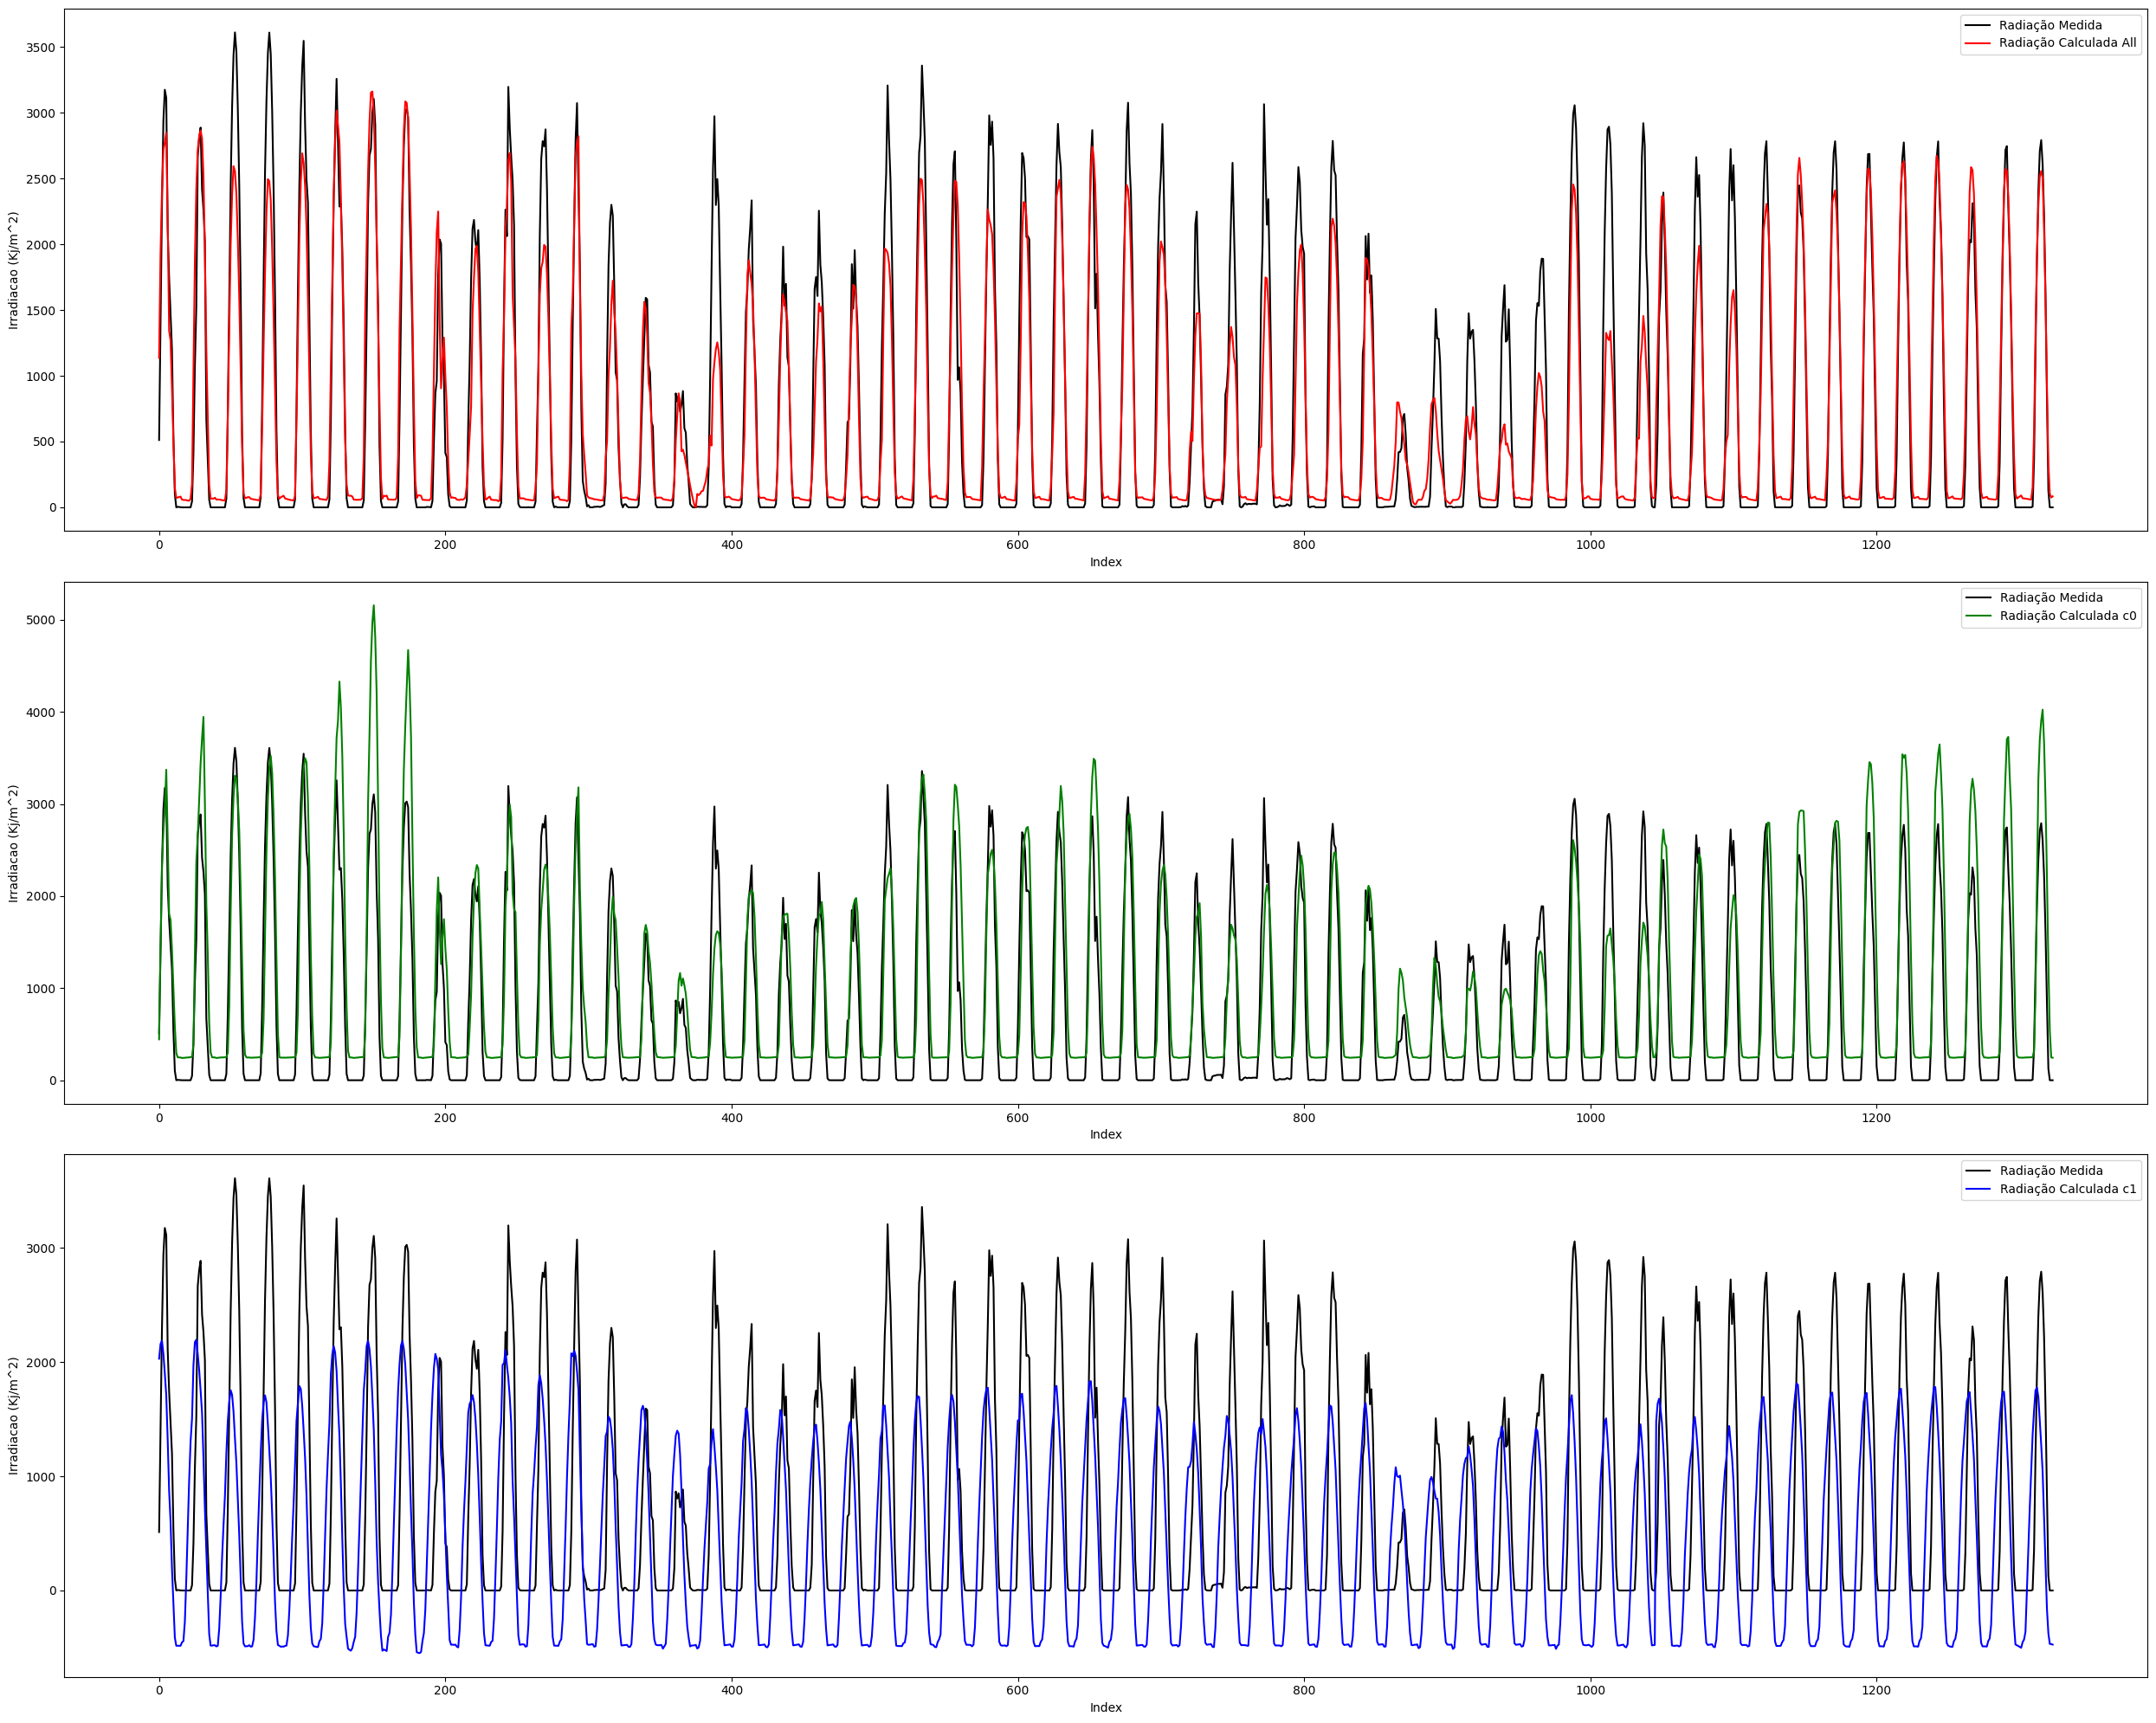

[OK]


In [19]:
data_prototype_final_nored = app(data_model_zero, data_prototype, 'ba')

In [20]:
data_prototype_final_nored

data  hora  temperatura    umidade  radiacao_medido  \
0    2024-03-09     8       30.975  62.250000          511.825   
1    2024-03-09     9       32.500  57.075000         1375.575   
2    2024-03-09    10       32.000  59.575000         2294.825   
3    2024-03-09    11       31.650  60.050000         2939.650   
4    2024-03-09    12       31.525  58.550000         3174.175   
...         ...   ...          ...        ...              ...   
1319 2024-05-05    17       30.125  39.950000          841.300   
1320 2024-05-05    18       29.450  41.750000          126.925   
1321 2024-05-05    19       29.225  41.850000            0.000   
1322 2024-05-05    20       29.050  41.725000            0.000   
1323 2024-05-05    21       28.800  42.133333            0.000   

      precipitacao_medido  radiacao_all  radiacao_c0  radiacao_c1  
0                    0.00   1135.852483   444.297058  2029.287828  
1                    0.00   1931.414720  1438.223185  2157.950164  
2                    0.00   2410.254207  2350.674696  2187.803786  
3                    0.00   2714.618394  2703.948632  2071.729662  
4                    0.05   2775.106855  2955.179694  1899.273109  
...                   ...           ...          ...          ...  
1319                 0.00    920.855942  2210.332730  -160.762594  
1320                 0.00    332.090912  1265.043150  -374.909584  
1321                 0.00    102.562388   540.343270  -468.498766  
1322                 0.00     74.735552   247.177764  -468.980161  
1323                 0.00     83.725127   244.568447  -474.106791  

[1324 rows x 9 columns]

Text(0, 0.5, 'irradiação (Kj/m2)')

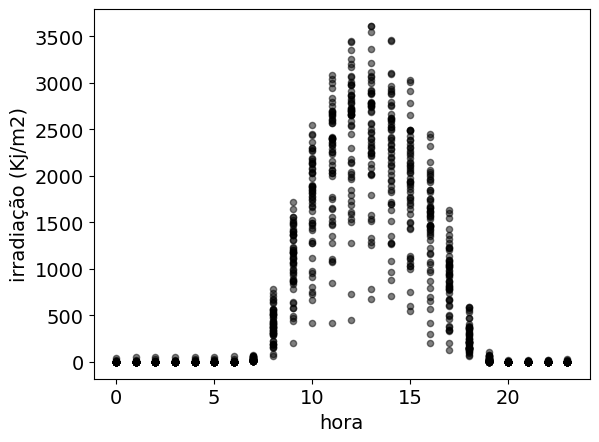

In [585]:
ax = data_prototype_final_nored.plot(kind="scatter", x="hora", y="radiacao_medido", alpha=0.5, color='black')
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel("hora", fontsize=14)
ax.set_ylabel("irradiação (Kj/m2)", fontsize=14) 

Text(0, 0.5, 'irradiação (Kj/m2)')

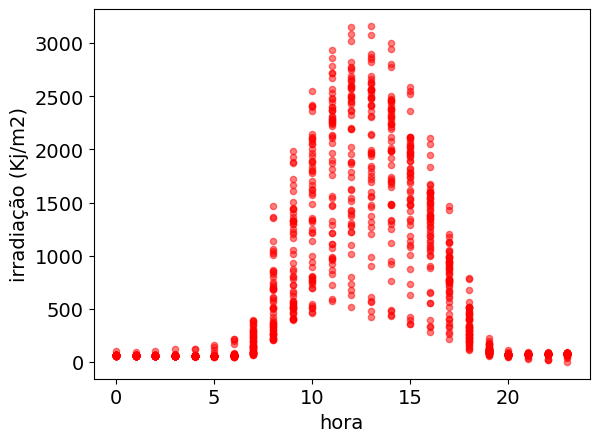

In [586]:
ax = data_prototype_final_nored.plot(kind="scatter", x="hora", y="radiacao_all", alpha=0.5, color='red')
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel("hora", fontsize=14)
ax.set_ylabel("irradiação (Kj/m2)", fontsize=14) 

Text(0, 0.5, 'irradiação (Kj/m2)')

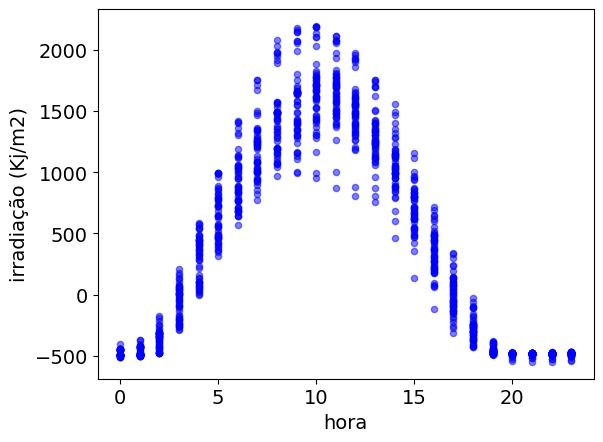

In [587]:
ax = data_prototype_final_nored.plot(kind="scatter", x="hora", y="radiacao_c0", alpha=0.5, color='blue')
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel("hora", fontsize=14)
ax.set_ylabel("irradiação (Kj/m2)", fontsize=14) 

Text(0, 0.5, 'irradiação (Kj/m2)')

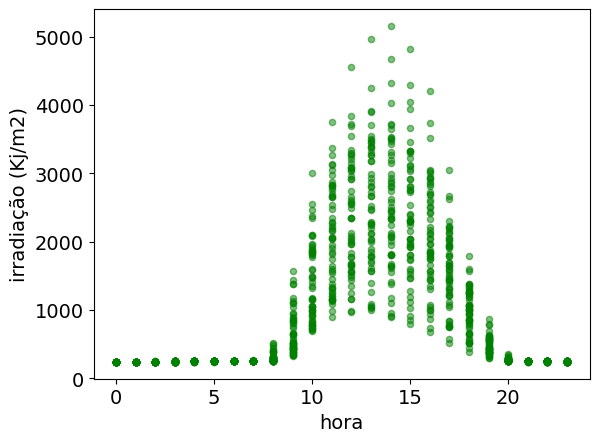

In [588]:
ax = data_prototype_final_nored.plot(kind="scatter", x="hora", y="radiacao_c1", alpha=0.5, color='green')
ax.tick_params(axis='both', which='both', labelsize=14)
ax.set_xlabel("hora", fontsize=14)
ax.set_ylabel("irradiação (Kj/m2)", fontsize=14) 

In [21]:
data_malok = data_prototype_final_nored.copy()


In [22]:
data_prototype_final_nored['radiacao_all'].min()

1.2480796268782797

In [23]:
data_prototype_final_nored['radiacao_c0'].min()

240.82913267592585

In [24]:
data_prototype_final_nored['radiacao_c1'].min()

-548.5687608284378

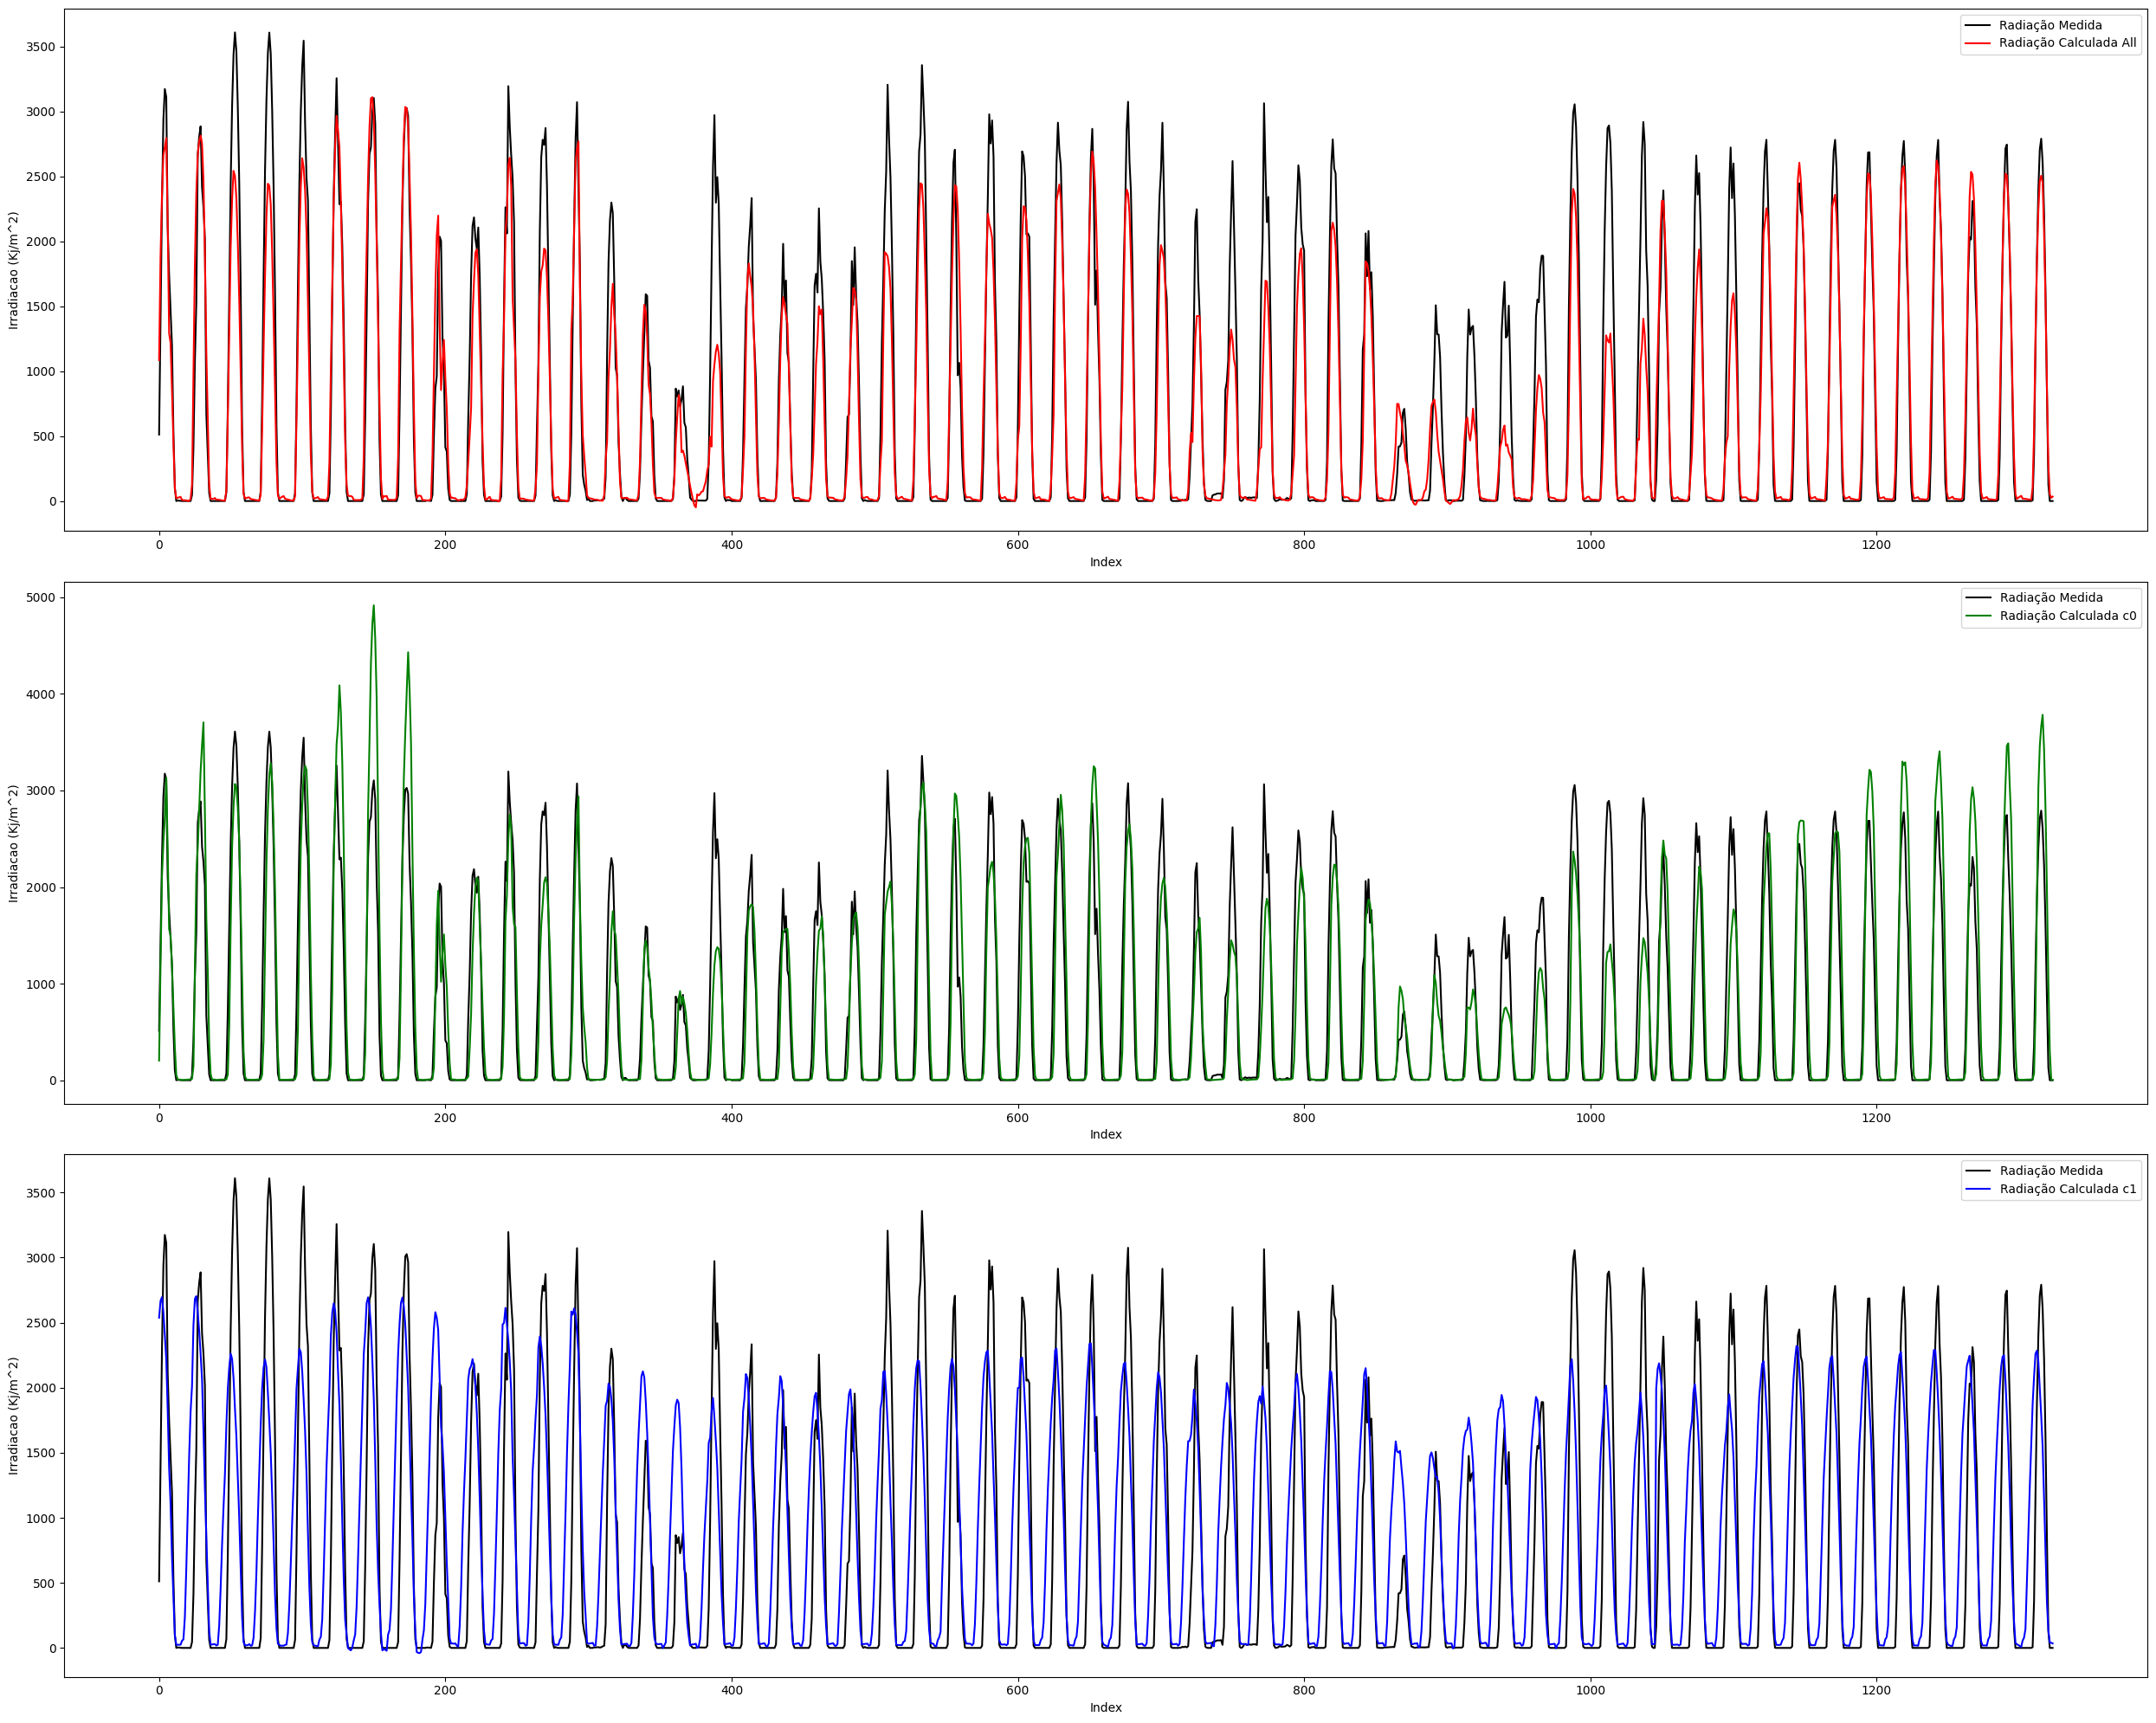


 All data [...]
Mean Absolute Error: 199.68768262313
Mean Squared Error: 134331.8073713634
Root Mean Squared Error: 366.5130384738903
R2 Score: 0.8621032535113956

 Cluster 0 [...]
Mean Absolute Error: 271.62041776542037
Mean Squared Error: 220314.01930821995
Root Mean Squared Error: 469.3762023241272
R2 Score: 0.773839218998645

 Cluster 1 [...]
Mean Absolute Error: 547.5682284180268
Mean Squared Error: 611053.8573894217
Root Mean Squared Error: 781.6993395093932
R2 Score: 0.3727298060513119


In [25]:
data_malok = data_prototype_final_nored.copy()

data_malok['radiacao_all'] = data_malok['radiacao_all'] - 50
data_malok['radiacao_c0'] = data_malok['radiacao_c0'] - 240.82913267592585
data_malok['radiacao_c1'] = data_malok['radiacao_c1'] + 508.5687608284378

fig, axs = plt.subplots(3, 1, figsize=(25, 20))

axs[0].plot(data_malok.index, data_malok['radiacao_medido'], color='black', label='Radiação Medida')
axs[0].plot(data_malok.index, data_malok['radiacao_all'], color='red', label='Radiação Calculada All')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Irradiacao (Kj/m^2)')
axs[0].legend()
axs[0].grid(False)

axs[1].plot(data_malok.index, data_malok['radiacao_medido'], color='black', label='Radiação Medida')
axs[1].plot(data_malok.index, data_malok['radiacao_c0'], color='green', label='Radiação Calculada c0')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Irradiacao (Kj/m^2)')
axs[1].legend()
axs[1].grid(False)

axs[2].plot(data_malok.index, data_malok['radiacao_medido'], color='black', label='Radiação Medida')
axs[2].plot(data_malok.index, data_malok['radiacao_c1'], color='blue', label='Radiação Calculada c1')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Irradiacao (Kj/m^2)')
axs[2].legend()
axs[2].grid(False)

plt.tight_layout()
plt.show()

print('\n All data [...]')
metricas(data_malok['radiacao_medido'], data_malok['radiacao_all'])

print('\n Cluster 0 [...]')
metricas(data_malok['radiacao_medido'], data_malok['radiacao_c0'])

print('\n Cluster 1 [...]')
metricas(data_malok['radiacao_medido'], data_malok['radiacao_c1'])

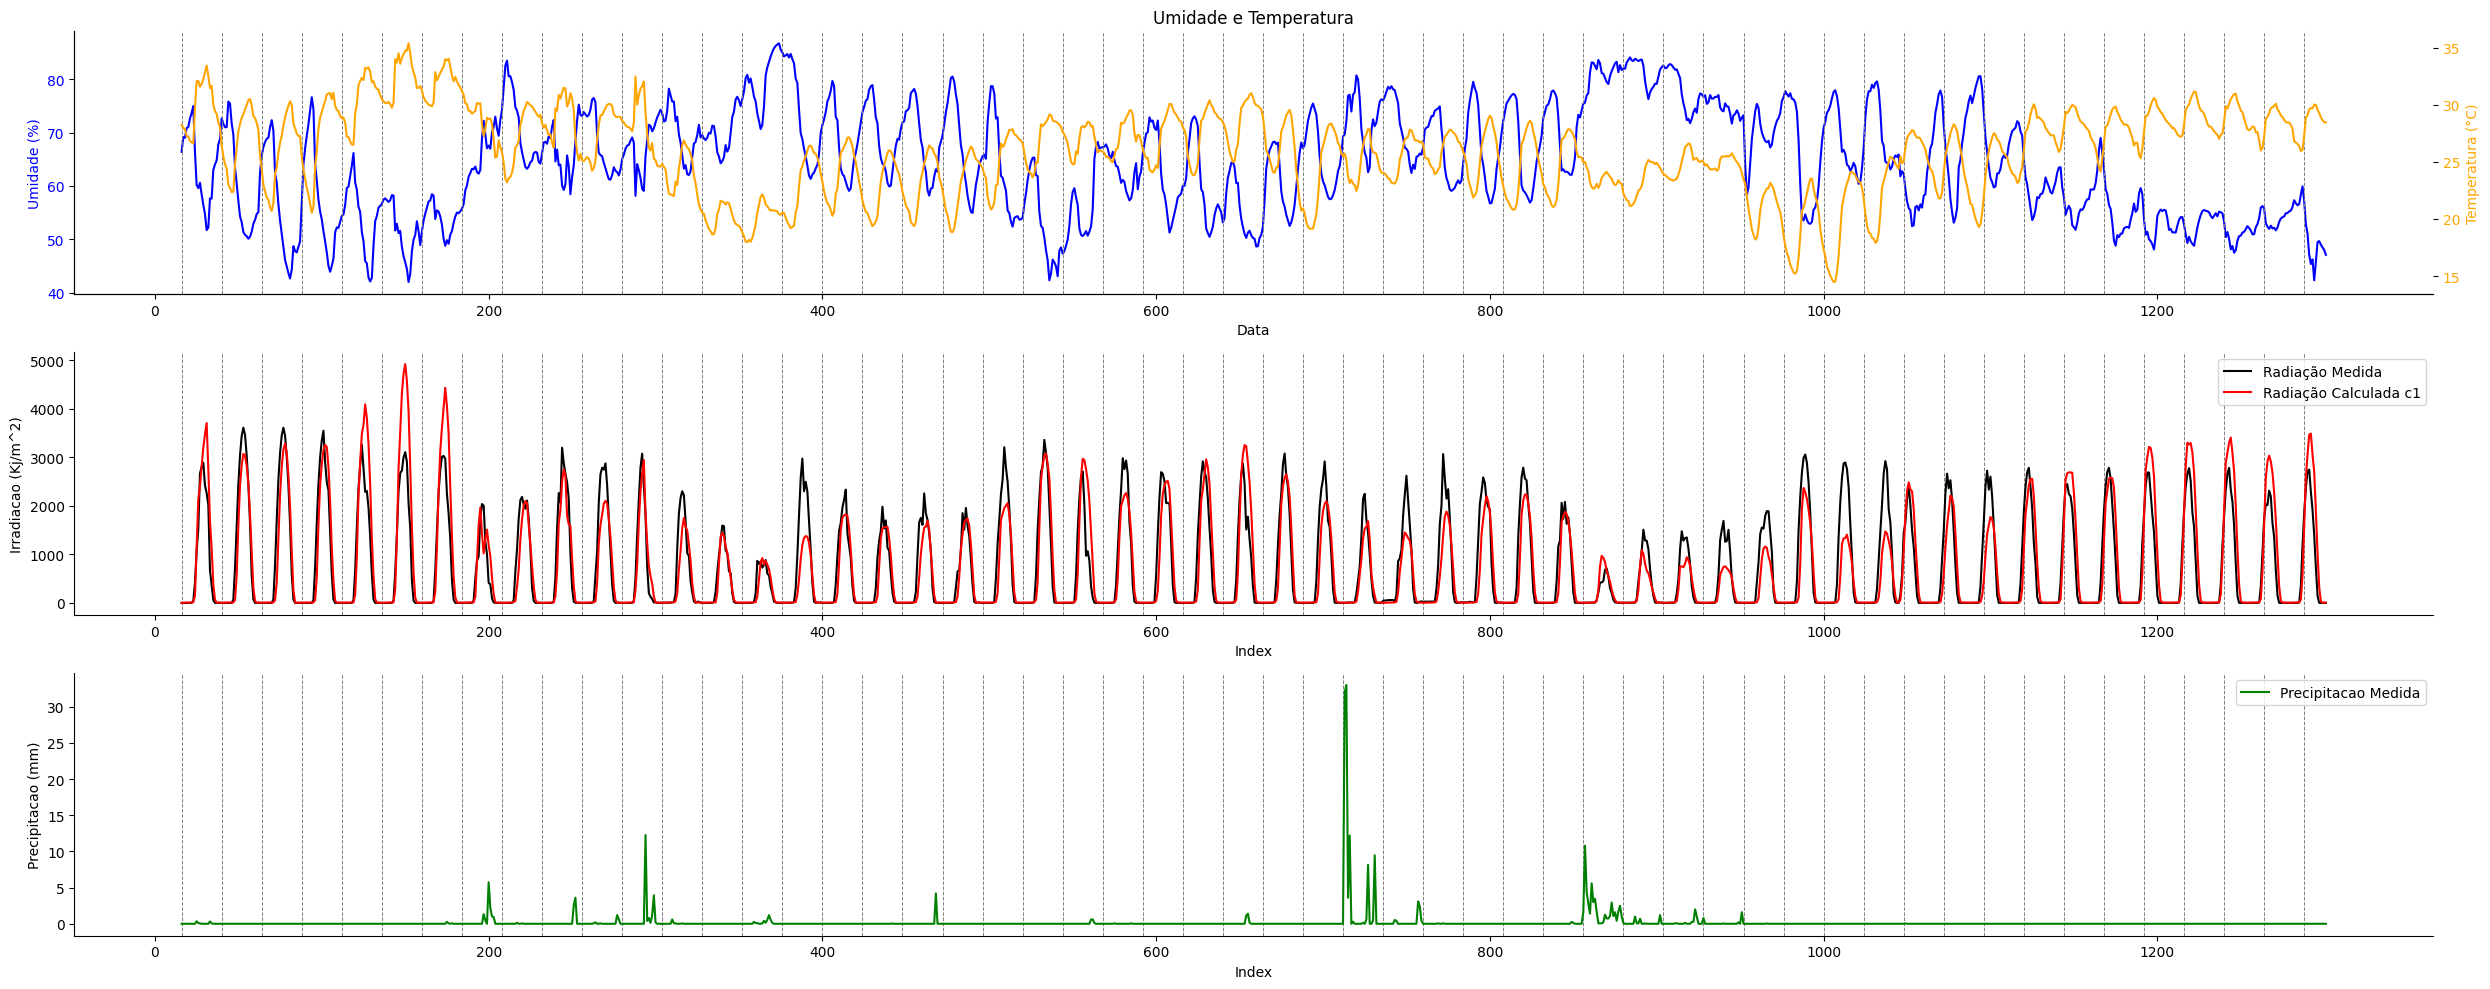

In [623]:
# Define the start and end dates for filtering
sd = '2024-03-10'
ed = '2024-05-04'

# Filter the DataFrame based on the date range
df_a = data_malok.query('data >= @sd and data <= @ed')

# Create a figure with 2 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(25, 10))

# Plot humidity and temperature on the first subplot with shared x-axis and dual y-axes
ax1_1 = ax1
ax1_2 = ax1.twinx()

ax1_1.plot(df_a.index, df_a['umidade'], color='blue', label='Umidade')
ax1_1.set_xlabel('Data')
ax1_1.set_ylabel('Umidade (%)', color='blue')
ax1_1.tick_params(axis='y', labelcolor='blue')
ax1_1.spines[['top', 'right']].set_visible(False)

ax1_2.plot(df_a.index, df_a['temperatura'], color='orange', label='Temperatura')
ax1_2.set_ylabel('Temperatura (°C)', color='orange')
ax1_2.tick_params(axis='y', labelcolor='orange')
ax1_2.spines[['top', 'right']].set_visible(False)

# Add vertical lines at each 7*24 index on the x-axis
for i in range(0, len(df_a), 24):
    ax1.axvline(x=df_a.index[i], color='grey', linestyle='--', linewidth=0.7)
    ax2.axvline(x=df_a.index[i], color='grey', linestyle='--', linewidth=0.7)
    ax3.axvline(x=df_a.index[i], color='grey', linestyle='--', linewidth=0.7)

# Title and legend for the first subplot
ax1.set_title('Umidade e Temperatura')
fig.tight_layout()

# Plot radiation data on the second subplot
ax2.plot(df_a.index, df_a['radiacao_medido'], color='black', label='Radiação Medida')
ax2.plot(df_a.index, df_a['radiacao_c1'], color='red', label='Radiação Calculada c1')
ax2.set_xlabel('Index')
ax2.set_ylabel('Irradiacao (Kj/m^2)')
ax2.legend()
ax2.spines[['top', 'right']].set_visible(False)

# Plot radiation data on the second subplot
ax3.plot(df_a.index, df_a['precipitacao_medido'], color='green', label='Precipitacao Medida')
ax3.set_xlabel('Index')
ax3.set_ylabel('Precipitacao (mm)')
ax3.legend()
ax3.spines[['top', 'right']].set_visible(False)


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [602]:
def plot_rads(rad_medido, rad_calculada):
    # Plotar os dois gráficos juntos
    fig, ax = plt.subplots(figsize=(25, 5))
    ax.plot(rad_medido, color='black', label='Radiacao Medida')
    ax.plot(rad_calculada, color='red', label='Radiacao Calculada')

    # Título e legenda
    plt.title('Radiacao Medida e Calculada')
    fig.tight_layout()
    ax.legend()

    # Mostrar o gráfico
    plt.show()

------------------------------
Semana 2024-03-10 - 2024-03-16
------------------------------
Mean Absolute Error: 360.71750203193363
Mean Squared Error: 370667.3277620963
Root Mean Squared Error: 608.8245459589292
R2 Score: 0.7564449239248994


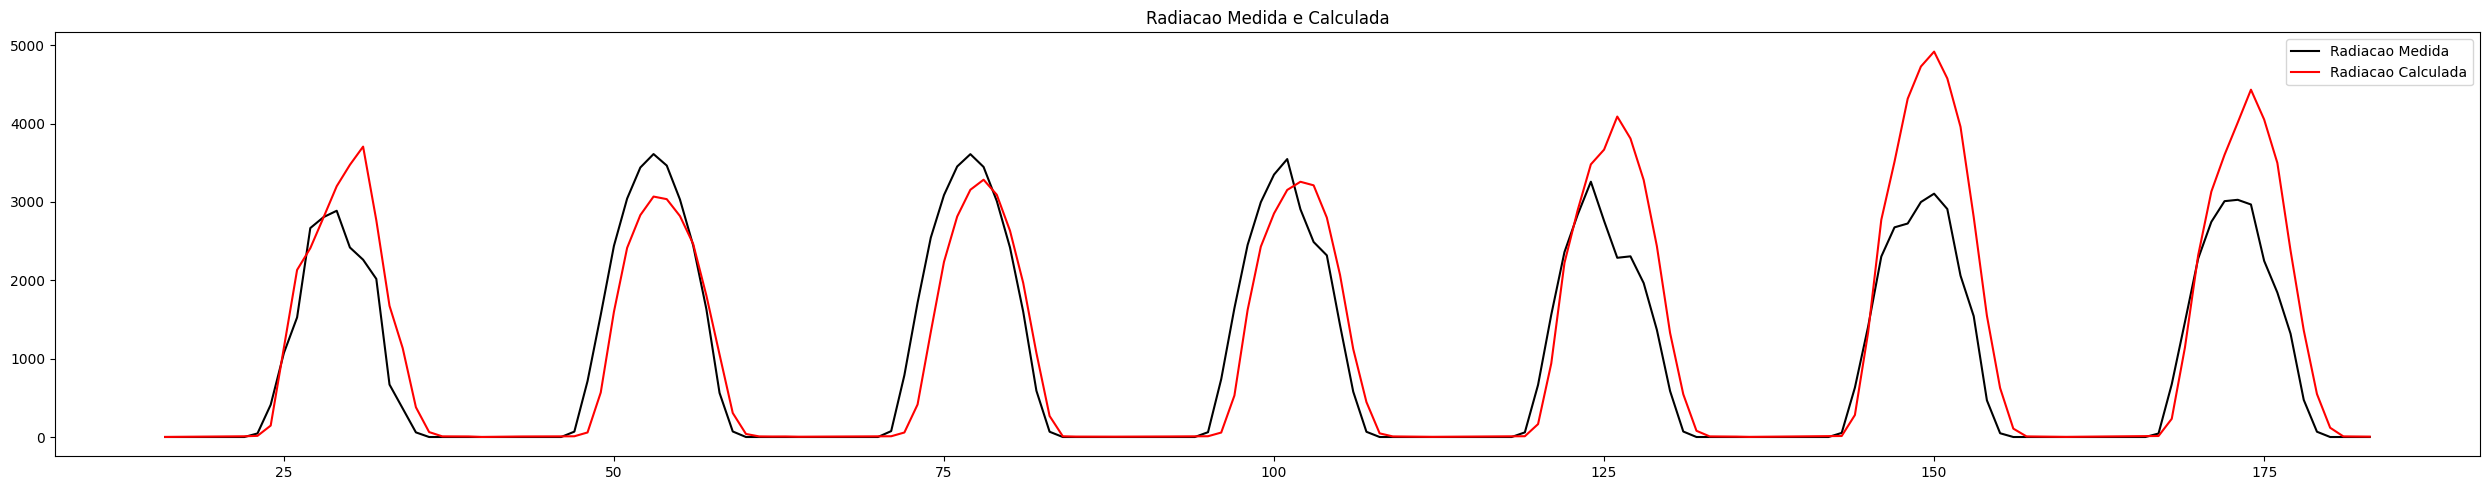

------------------------------
Semana 2024-03-17 - 2024-03-23
------------------------------
Mean Absolute Error: 213.94080610097922
Mean Squared Error: 132764.8409888832
Root Mean Squared Error: 364.36909993697765
R2 Score: 0.8415635038685942


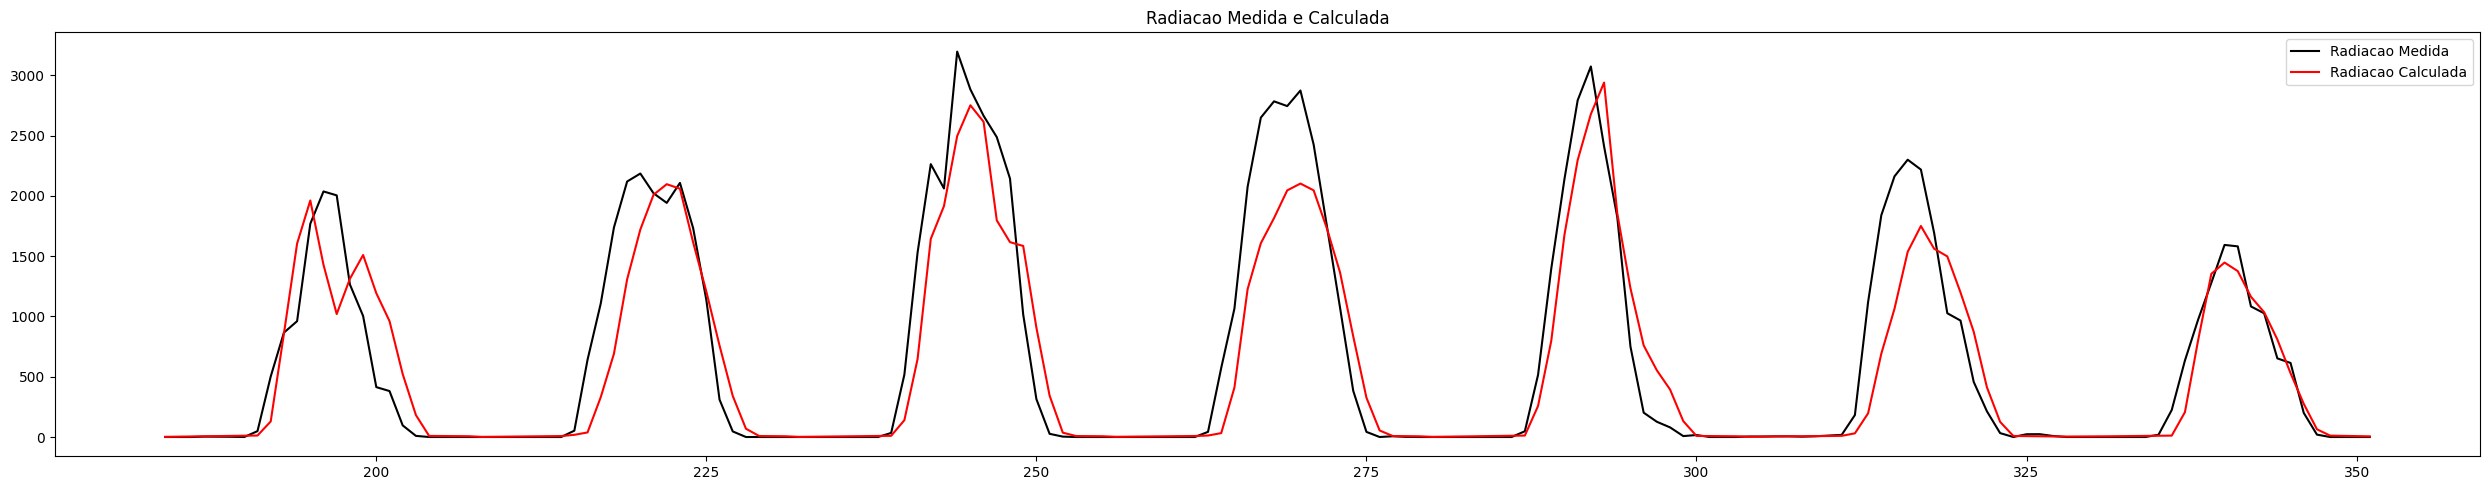

------------------------------
Semana 2024-03-24 - 2024-03-30
------------------------------
Mean Absolute Error: 207.84335253873675
Mean Squared Error: 153600.81476355795
Root Mean Squared Error: 391.91939829964775
R2 Score: 0.773023340149913


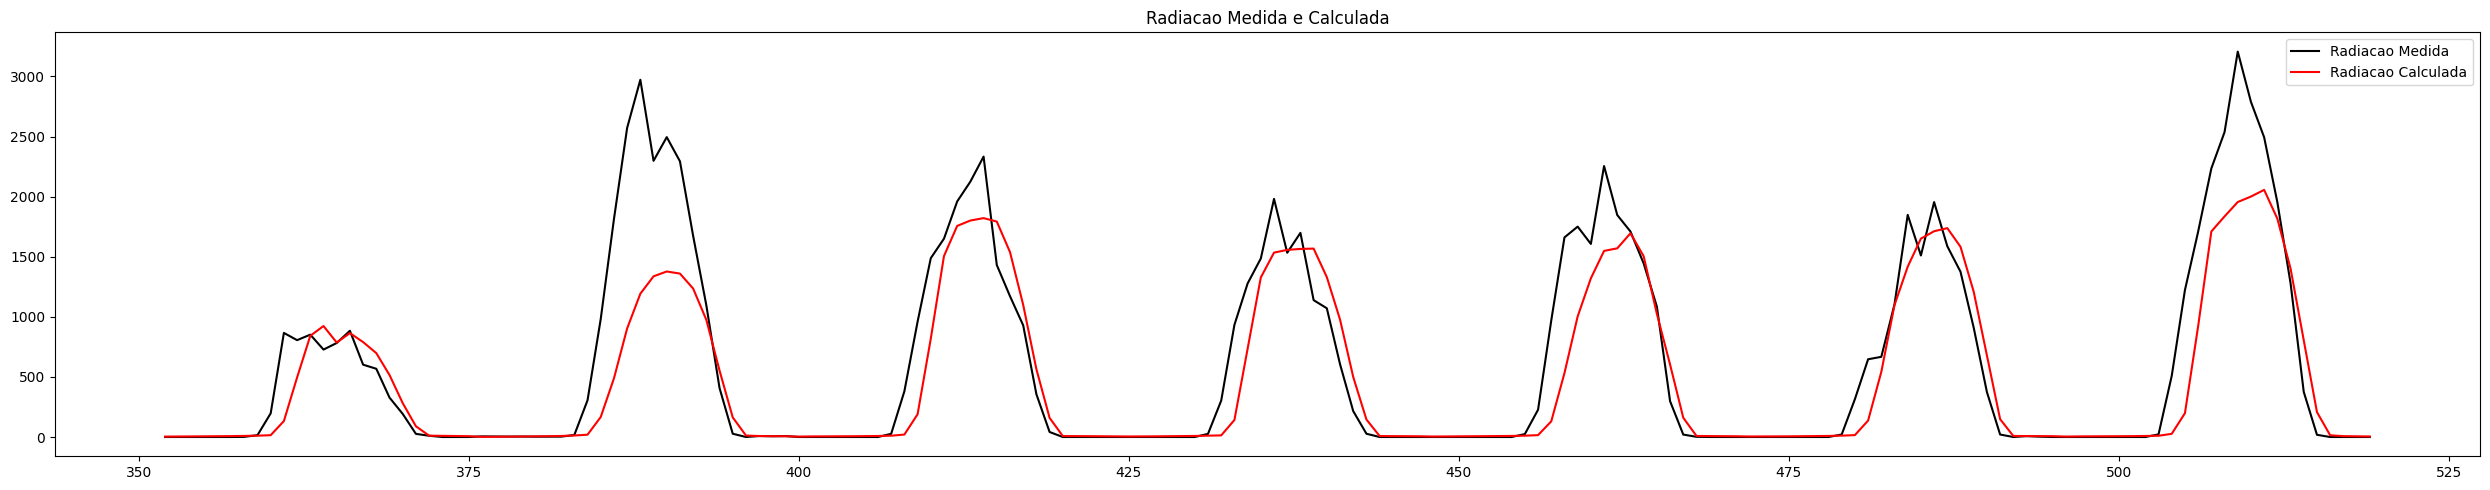

------------------------------
Semana 2024-03-31 - 2024-04-06
------------------------------
Mean Absolute Error: 286.7799099253162
Mean Squared Error: 231029.14676655582
Root Mean Squared Error: 480.6549144308792
R2 Score: 0.7949393049837326


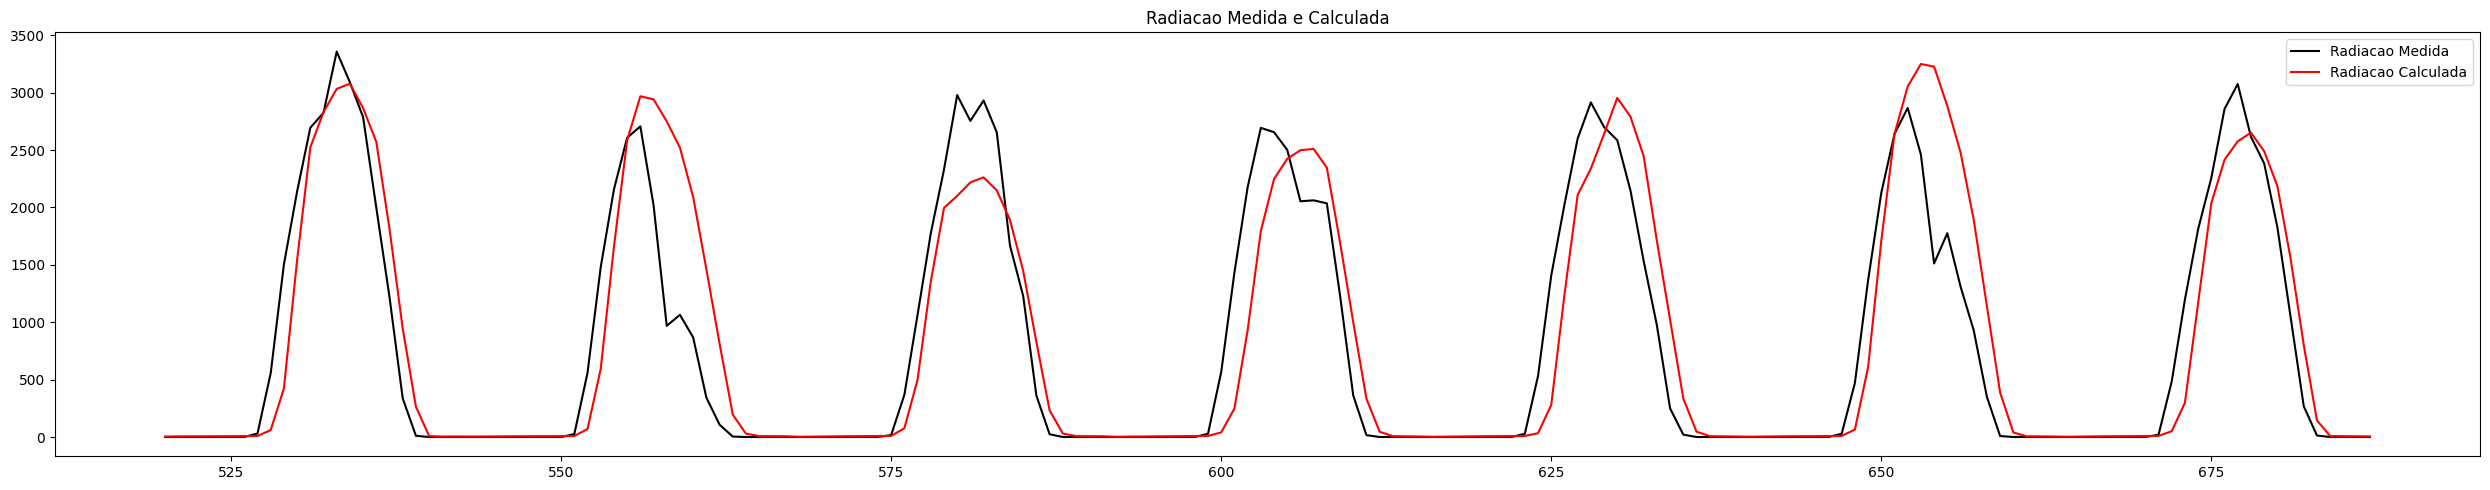

------------------------------
Semana 2024-04-07 - 2024-04-13
------------------------------
Mean Absolute Error: 240.9357450950018
Mean Squared Error: 175005.35729428142
Root Mean Squared Error: 418.3364164094269
R2 Score: 0.7936218302399493


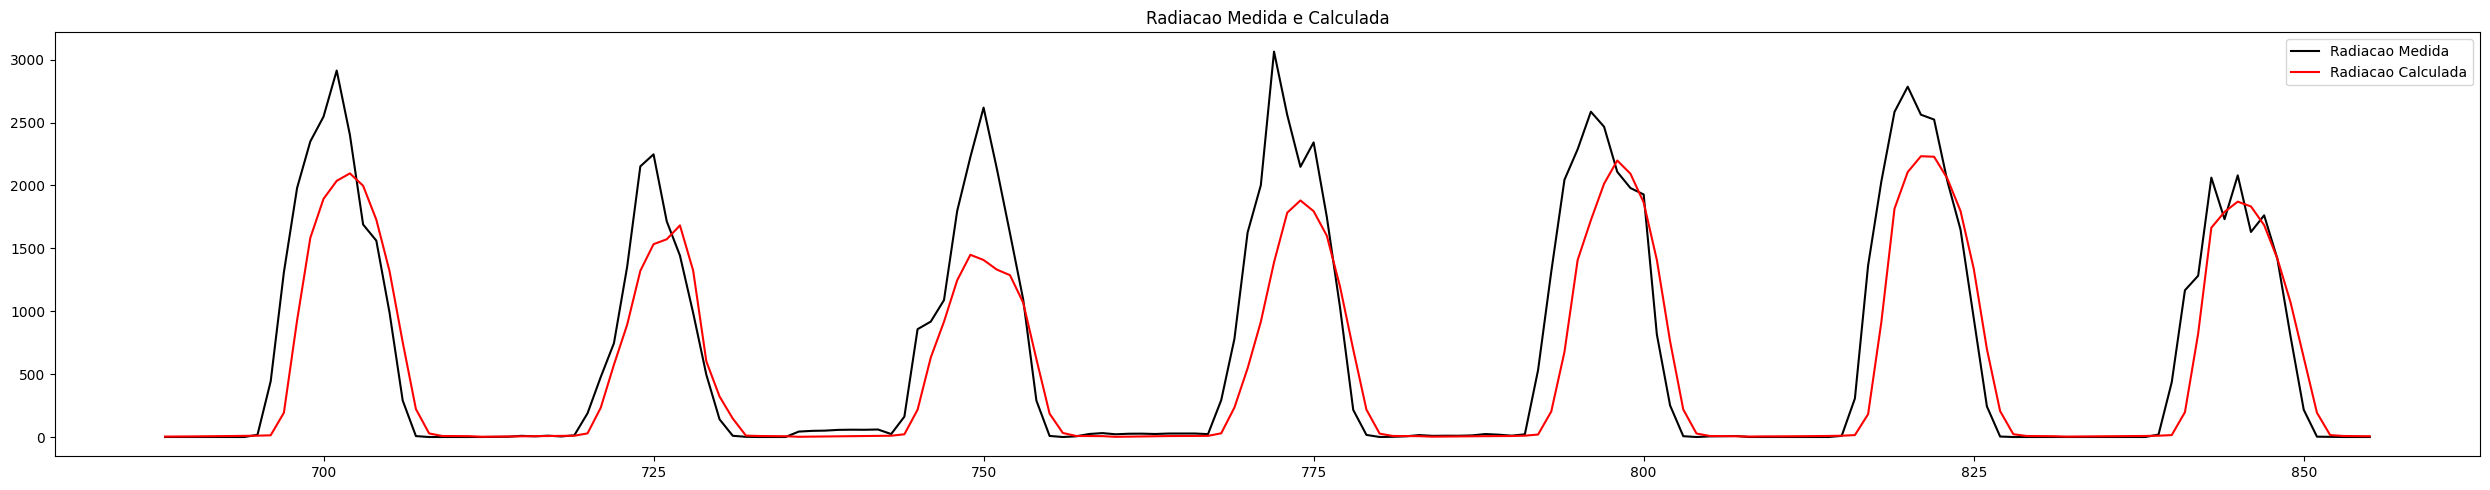

------------------------------
Semana 2024-04-14 - 2024-04-20
------------------------------
Mean Absolute Error: 237.07839813897257
Mean Squared Error: 195551.82016850455
Root Mean Squared Error: 442.2124152129885
R2 Score: 0.6972278654093038


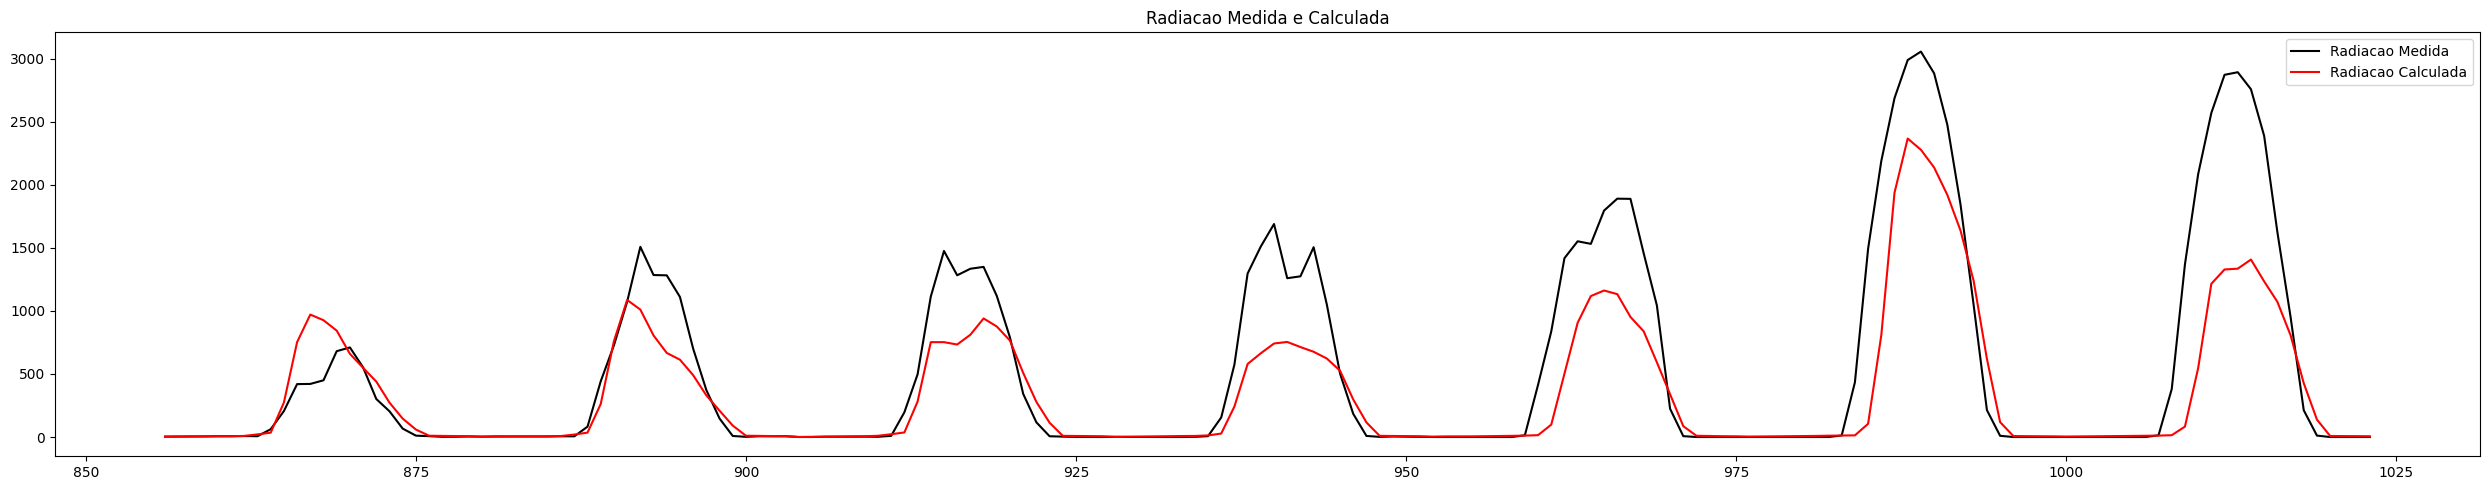

------------------------------
Semana 2024-04-21 - 2024-04-27
------------------------------
Mean Absolute Error: 324.0888098193885
Mean Squared Error: 266770.0414444343
Root Mean Squared Error: 516.4978619940593
R2 Score: 0.7231437300270819


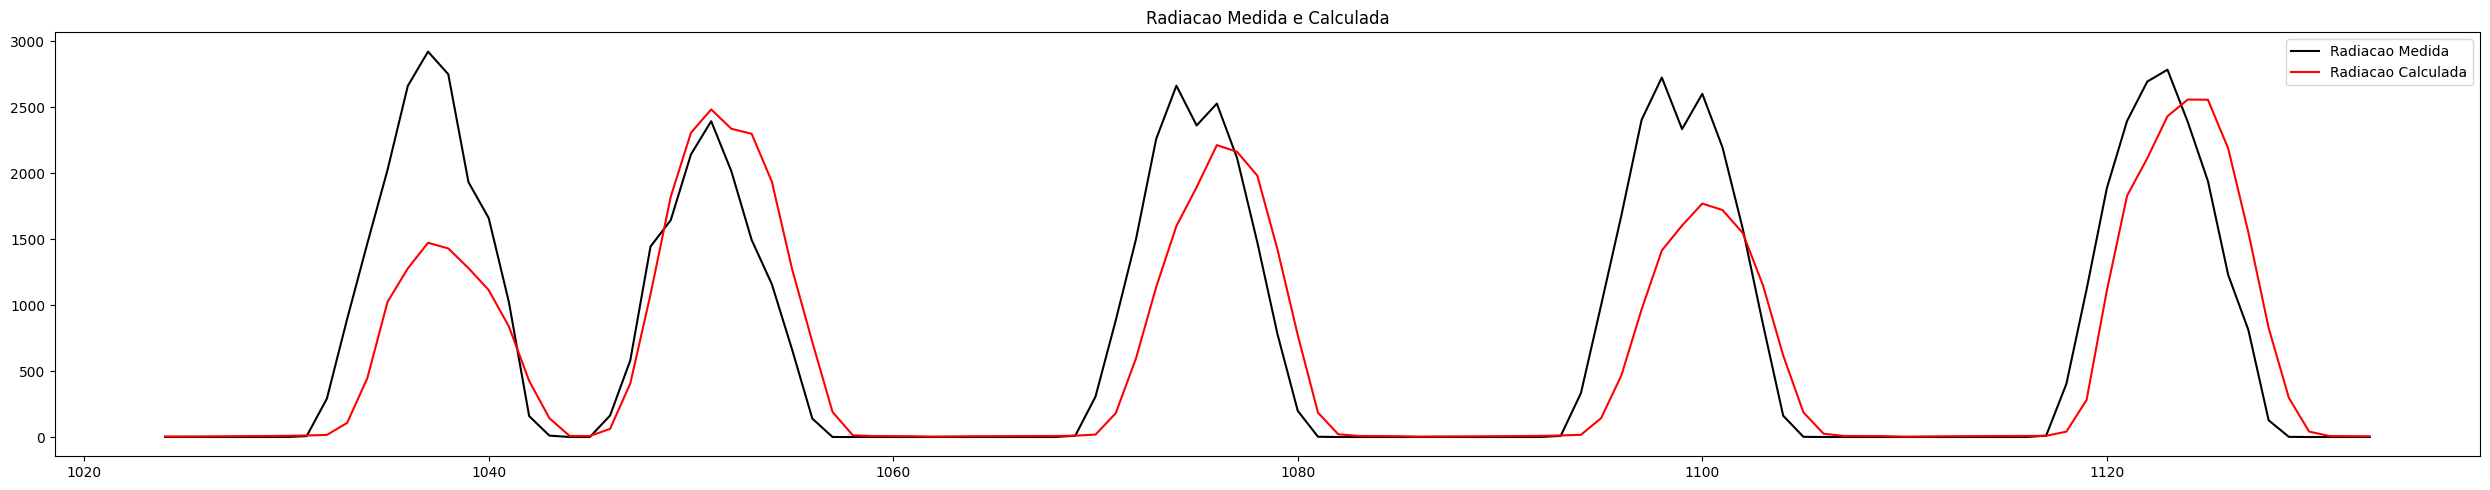

------------------------------
Semana 2024-04-28 - 2024-05-04
------------------------------
Mean Absolute Error: 311.56731614614057
Mean Squared Error: 247725.52312609233
Root Mean Squared Error: 497.72032621351957
R2 Score: 0.7408281951456717


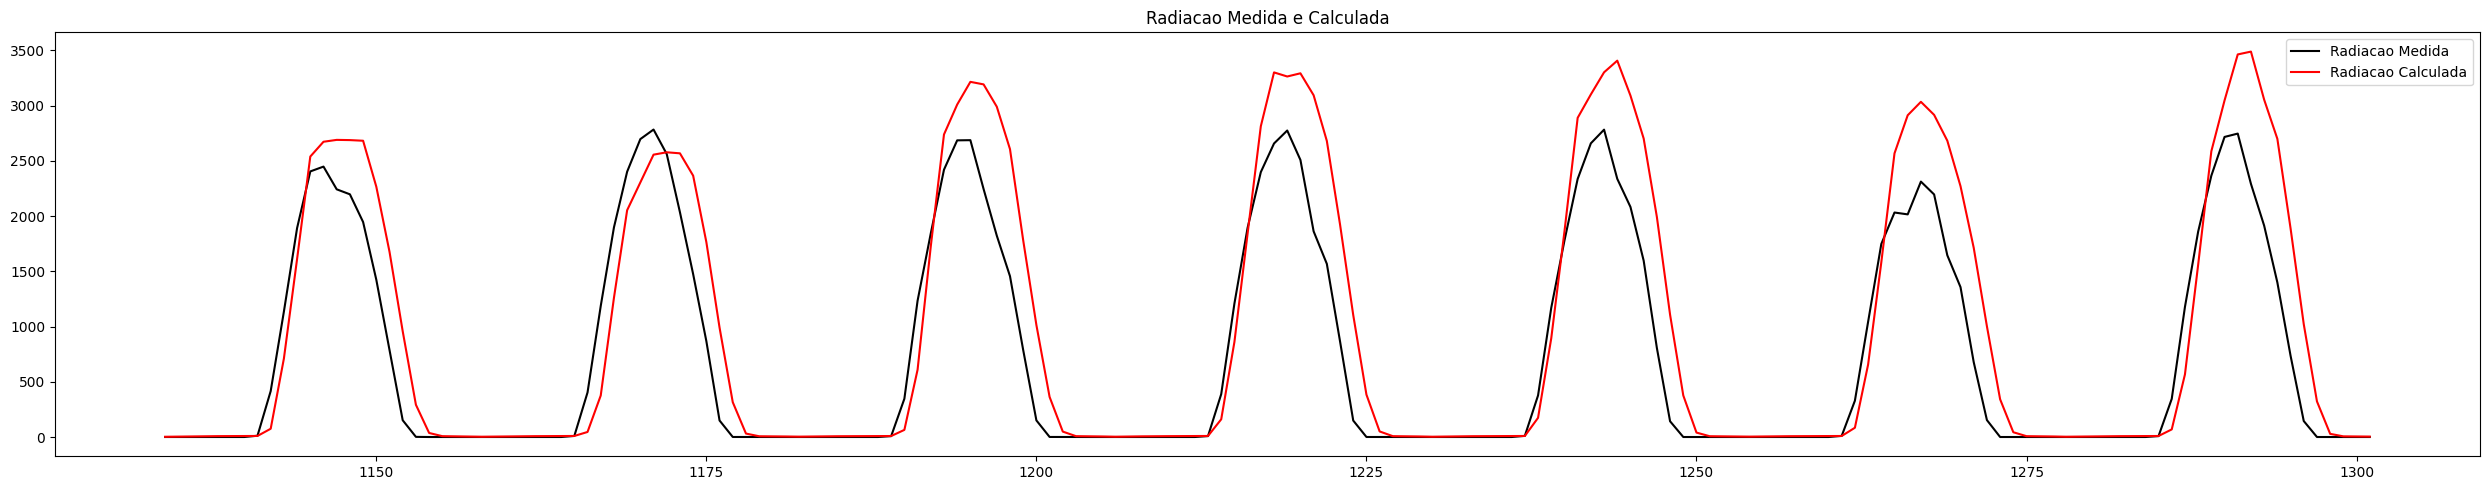

In [605]:
list_stat_date = ['2024-03-10', '2024-03-17', '2024-03-24', '2024-03-31', '2024-04-07', '2024-04-14', '2024-04-21', '2024-04-28']
list_end_date =  ['2024-03-16', '2024-03-23', '2024-03-30', '2024-04-06', '2024-04-13', '2024-04-20', '2024-04-27', '2024-05-04']

for sd, ed in zip(list_stat_date, list_end_date):
    
    print('-'*30)
    print(f'Semana {sd} - {ed}')
    print('-'*30)
    df_a = data_malok.query('data >= @sd and data <= @ed')
    metricas(df_a['radiacao_medido'], df_a['radiacao_c1'])
    plot_rads(df_a['radiacao_medido'], df_a['radiacao_c1'])

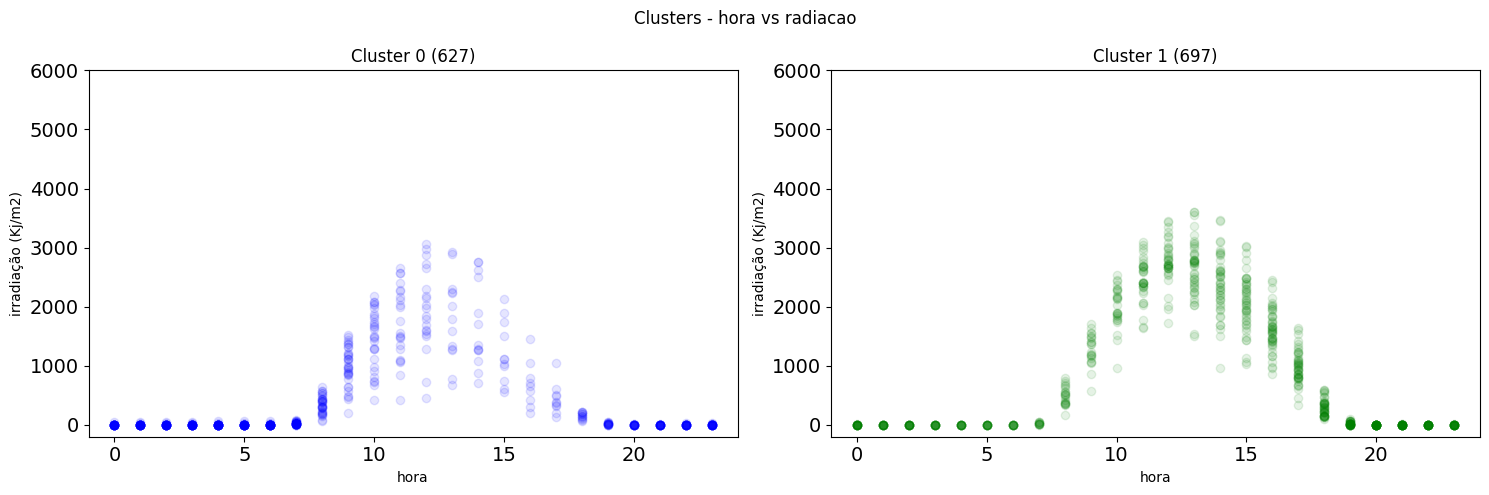

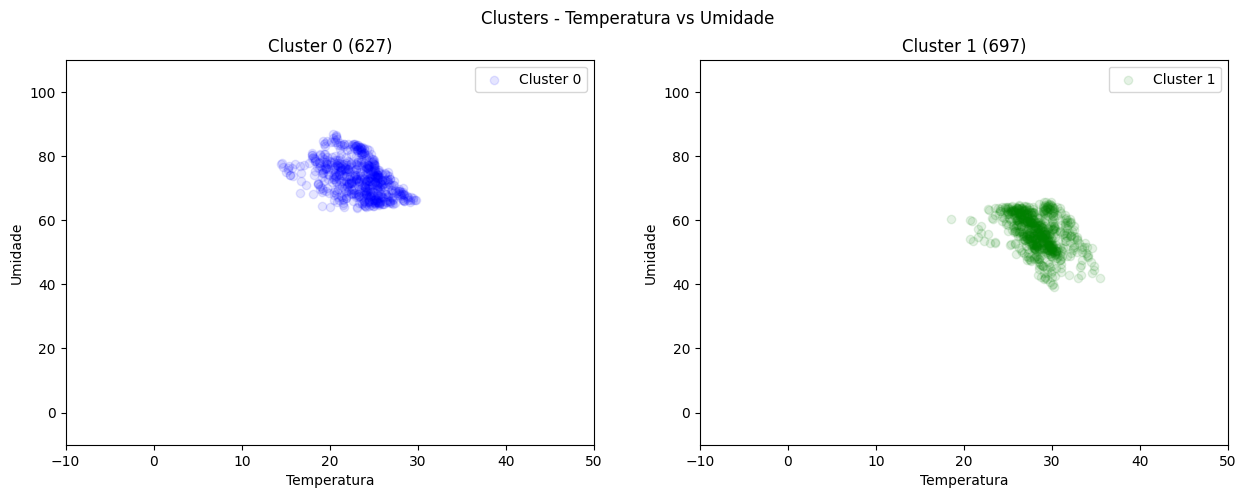

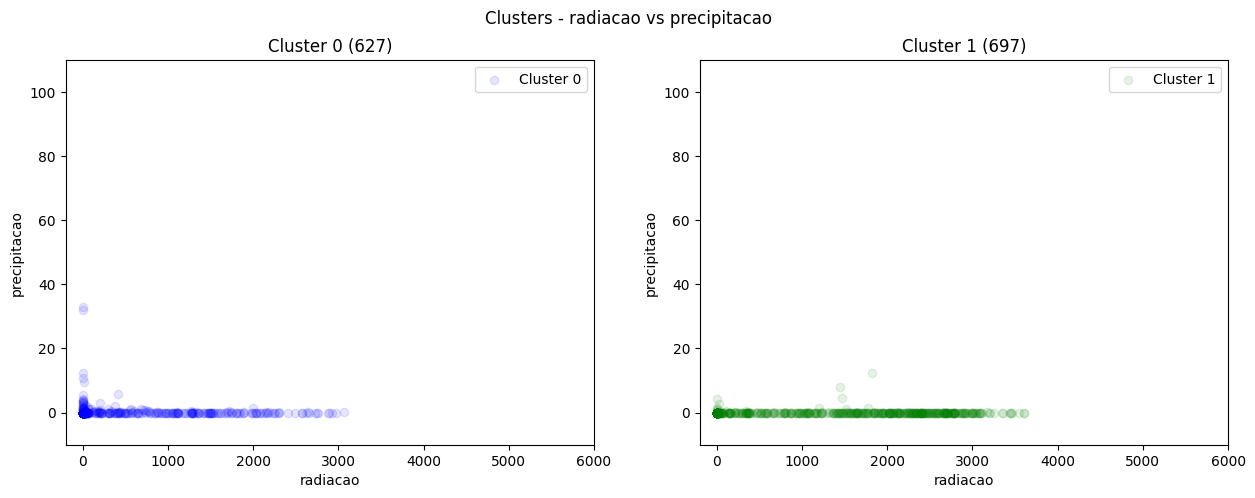

In [620]:
df_c0, df_c1 = clustering_Kmeans(data_prototype.copy(), ['temperatura', 'umidade'])

---
---

In [624]:
data_prototype_final_red

data  hora  temperatura    umidade  radiacao_medido  \
0    2024-03-09     8       30.975  62.250000          511.825   
1    2024-03-09     9       32.500  57.075000         1375.575   
2    2024-03-09    10       32.000  59.575000         2294.825   
3    2024-03-09    11       31.650  60.050000         2939.650   
4    2024-03-09    12       31.525  58.550000         3174.175   
...         ...   ...          ...        ...              ...   
1319 2024-05-05    17       30.125  39.950000          841.300   
1320 2024-05-05    18       29.450  41.750000          126.925   
1321 2024-05-05    19       29.225  41.850000            0.000   
1322 2024-05-05    20       29.050  41.725000            0.000   
1323 2024-05-05    21       28.800  42.133333            0.000   

      precipitacao_medido  radiacao_all  radiacao_c0  radiacao_c1  
0                    0.00   1535.966538  1824.213066  1278.927513  
1                    0.00   1878.081028  1826.002235  1771.044978  
2                    0.00   2056.926365  1850.379325  1957.009656  
3                    0.00   2154.909210  1853.496250  2069.076183  
4                    0.05   2227.892736  1823.075710  2165.393868  
...                   ...           ...          ...          ...  
1319                 0.00   1625.597989   635.810348  2536.440615  
1320                 0.00   1389.566868   396.366224  2255.761166  
1321                 0.00   1194.684408   139.704572  2045.777815  
1322                 0.00    892.232002  -138.652762  1827.897671  
1323                 0.00    595.459957  -411.754312  1599.290734  

[1324 rows x 9 columns]

In [625]:
print(data_prototype_final_red['radiacao_all'].min())

print(data_prototype_final_red['radiacao_c0'].min())

print(data_prototype_final_red['radiacao_c1'].min())

-788.940190213713
-1120.7863612473425
-565.0675920230796


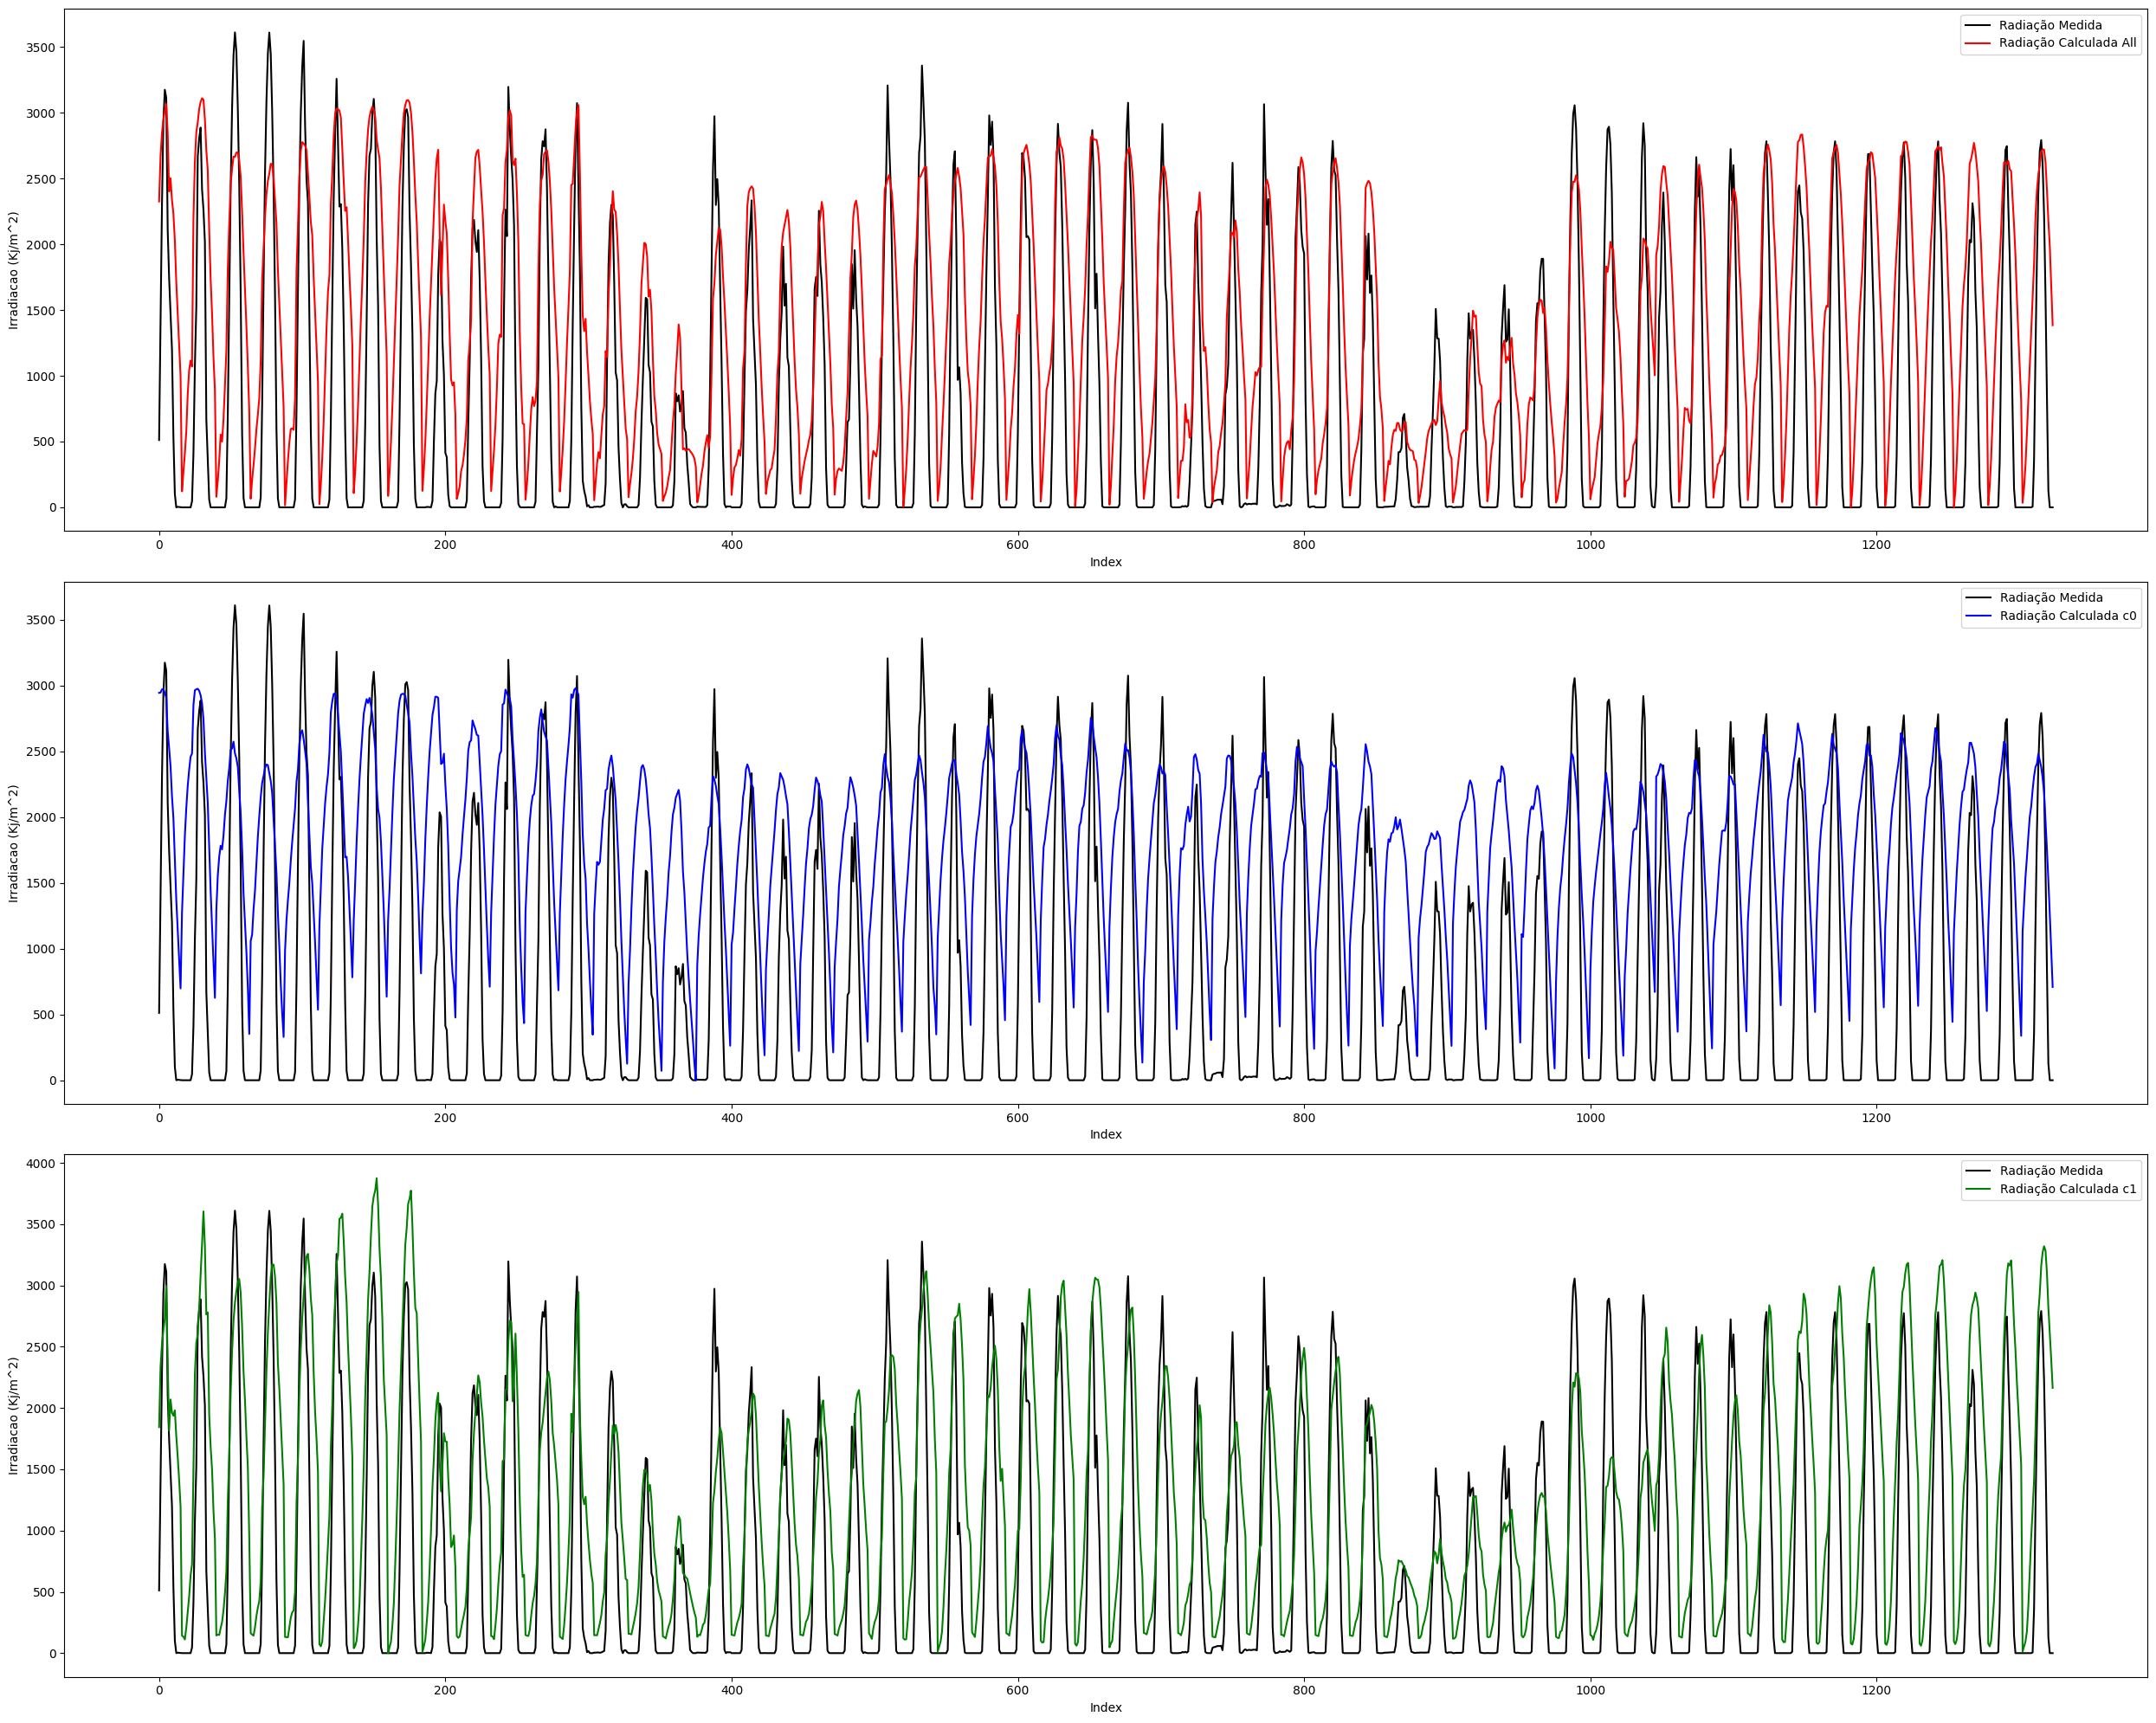


 All data [...]
Mean Absolute Error: 751.1968186506768
Mean Squared Error: 872603.6895908312
Root Mean Squared Error: 934.1325867299734
R2 Score: 0.1042388833802046

 Cluster 0 [...]
Mean Absolute Error: 1121.0107239792915
Mean Squared Error: 1663733.4908536186
Root Mean Squared Error: 1289.857934368595
R2 Score: -0.7078861656241693

 Cluster 1 [...]
Mean Absolute Error: 725.7232475622488
Mean Squared Error: 934071.8178524984
Root Mean Squared Error: 966.4739095560202
R2 Score: 0.04113949488917257


In [627]:
data_malok_red = data_prototype_final_red.copy()

data_malok_red['radiacao_all'] = data_malok_red['radiacao_all'] + 788.940190213713
data_malok_red['radiacao_c0'] = data_malok_red['radiacao_c0'] + 1120.7863612473425
data_malok_red['radiacao_c1'] = data_malok_red['radiacao_c1'] + 565.0675920230796

fig, axs = plt.subplots(3, 1, figsize=(25, 20))

axs[0].plot(data_malok_red.index, data_malok_red['radiacao_medido'], color='black', label='Radiação Medida')
axs[0].plot(data_malok_red.index, data_malok_red['radiacao_all'], color='red', label='Radiação Calculada All')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Irradiacao (Kj/m^2)')
axs[0].legend()
axs[0].grid(False)

axs[1].plot(data_malok_red.index, data_malok_red['radiacao_medido'], color='black', label='Radiação Medida')
axs[1].plot(data_malok_red.index, data_malok_red['radiacao_c0'], color='blue', label='Radiação Calculada c0')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Irradiacao (Kj/m^2)')
axs[1].legend()
axs[1].grid(False)

axs[2].plot(data_malok_red.index, data_malok_red['radiacao_medido'], color='black', label='Radiação Medida')
axs[2].plot(data_malok_red.index, data_malok_red['radiacao_c1'], color='green', label='Radiação Calculada c1')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Irradiacao (Kj/m^2)')
axs[2].legend()
axs[2].grid(False)

plt.tight_layout()
plt.show()

print('\n All data [...]')
metricas(data_malok_red['radiacao_medido'], data_malok_red['radiacao_all'])

print('\n Cluster 0 [...]')
metricas(data_malok_red['radiacao_medido'], data_malok_red['radiacao_c0'])

print('\n Cluster 1 [...]')
metricas(data_malok_red['radiacao_medido'], data_malok_red['radiacao_c1'])